# Chapter 3: Tuned gain control model

Last access (y.m.d): 22.10.18  
Last update (y.m.d): 22.10.18

In [3855]:
import pandas as pd
import pdb
import model_responses_pytorch as mrpt
import plot_superposition_func as psf
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

import warnings
warnings.filterwarnings(action='once')

import numpy as np
import os
import helper_fcns as hf
# import model_responses as mr
import scipy.stats as ss
import scipy.odr.odrpack as odrpack
from scipy.stats.mstats import gmean
from scipy.stats import ks_2samp, kstest, linregress
import itertools
import autoreload
from IPython.core.display import display, HTML, Image

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import matplotlib.backends.backend_pdf as pltSave
from matplotlib.ticker import FuncFormatter

from helper_fcns_sfBB import compute_f1f0 as bb_compute_f1f0
from helper_fcns_sfBB import get_resp_str

import plot_sf_figs as psf

# plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');

base_dir = os.getcwd() + '/';

%matplotlib inline

In [494]:
from matplotlib import rcParams

tex_width = 469; # per \layout in Overleaf on document
sns_offset = 2; 
hist_width = 0.9;
hist_ytitle = 0.94; # moves the overall title a bit further down on histogram plots0

rcParams.update(mpl.rcParamsDefault)

fontsz = 12;
tick_scalar = 1.5;

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
params = {'text.usetex' : True,
          'font.size' : fontsz,
          'font.family': 'lmodern',
           'font.style': 'italic'}
plt.rcParams.update(params)

# rcParams['lines.linewidth'] = 2.5;
rcParams['lines.markeredgewidth'] = 0; # no edge, since weird tings happen then
# rcParams['axes.linewidth'] = 2; # was 1.5
# rcParams['lines.markersize'] = 5;

tick_adj = ['xtick.major.size', 'xtick.minor.size', 'ytick.major.size', 'ytick.minor.size']
for adj in tick_adj:
    rcParams[adj] = rcParams[adj] * tick_scalar;
    
%matplotlib inline

date = '_221004'

saveName = 'figures/reports/ch03_superpos_masks%s/' % (date); # for one save name for all figures
save_loc = base_dir + saveName;

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  app.launch_new_instance()


# 1. Model debugging

As of 22.10.04, realize we need to tune all of the optimization hyperparameters if we're going to use pytorch!

## 1.1 Exploring the hyperparameters

In [11]:
cellNum = 40
expDir = 'V1/'
respMeasure = 0; # dc [0] or f1 [1]

excType = 2; # 1 is deriv. order, 2 is flex. gauss
lossType = 1
fitType = 2 # flat [1], tuned [2] or gain tuned[5]
lgnFrontOn = 1
lgnConType = 1
_LGNforNorm = 0

In [20]:
autoreload.reload(mrpt);

In [45]:
batch_size = [64, 128, 256, 512]
epochs = 250
lr = 0.01
dt_loss = [];
for bs in batch_size:
    fit, details = mrpt.setModel(cellNum, expDir, excType, lossType, fitType, lgnFrontOn, lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm, trackSteps=1, learning_rate=lr, batch_size=bs, max_epochs = epochs, respMeasure=respMeasure, newMethod=1, vecCorrected=0, scheduler=False, to_save=False, )
    dt_loss.append([np.mean(x) for x in details['loss']])


FitList: fitList_pyt_221004_LGN_wght_sqrt.npy [expDir is V1/]
loading data structure from /arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/V1/structures/...
expInd is 5
respMeasure, vecCorrected: 0, 0

********MODEL PARAMETERS********
prefSf: 1.89
sigma l|r: -1.76|0.32
mWeight: 0.30 (orig -0.86)
scalar|early|late: 0.349|0.091|-0.031
norm. const.: -2.00
tuned norm mn|std: 1.31|1.00
No LGN for GC
********END OF MODEL PARAMETERS********

cell 40: rem. is 48 [last iteration]

****** STEP 0 [dc] [t=20:14:14] [prev loss: nan] *********
...finished. New NLL (4.63) vs. previous NLL (10000000.00)

FitList: fitList_pyt_221004_LGN_wght_sqrt.npy [expDir is V1/]
loading data structure from /arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/V1/structures/...
expInd is 5
respMeasure, vecCorrected: 0, 0

********MODEL PARAMETERS********
prefSf: 1.53
sigma l|r: -0.87|0.34
mWeight: 0.66 (orig 0.68)
scalar|early|late: 0.022|-0.067|-0.337
norm. const.: -2.00
tuned norm mn|std: 1.12|1.94

This was with lr = 0.01, epochs = 250, NO scheduler

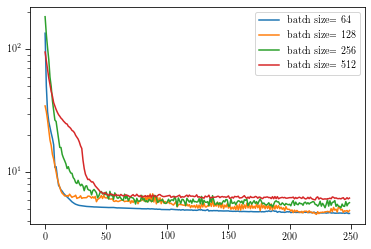

In [65]:
for ii, val in enumerate(dt_loss):

    plt.plot(val, label='batch size= %d' % batch_size[ii]);

plt.yscale('log')
plt.legend();

This was with lr = 0.05, epochs = 100, NO scheduler

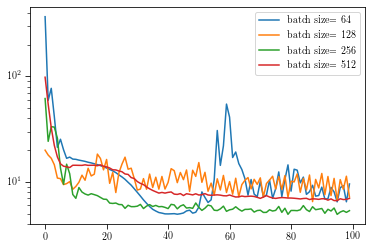

In [43]:
for ii, val in enumerate(dt_loss):

    plt.plot(val, label='batch size= %d' % batch_size[ii]);

plt.yscale('log')
plt.legend();

This was with lr = 0.01, epochs = 100, but NO scheduler (Run again)

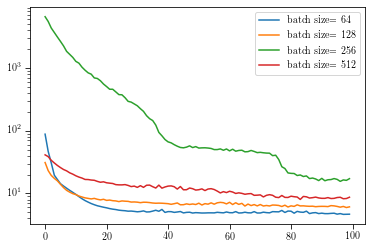

In [41]:
for ii, val in enumerate(dt_loss):

    plt.plot(val, label='batch size= %d' % batch_size[ii]);

plt.yscale('log')
plt.legend();

This was with lr = 0.01, epochs = 100, but NO scheduler (Run again)

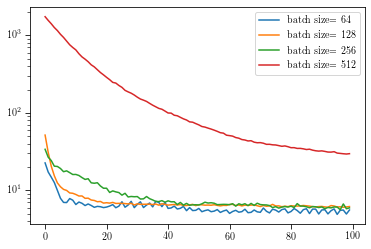

In [39]:
for ii, val in enumerate(dt_loss):

    plt.plot(val, label='batch size= %d' % batch_size[ii]);

plt.yscale('log')
plt.legend();

This was with lr = 0.01, epochs = 100

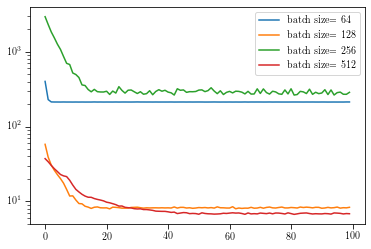

In [37]:
for ii, val in enumerate(dt_loss):

    plt.plot(val, label='batch size= %d' % batch_size[ii]);

plt.yscale('log')
plt.legend();

This was with lr = 0.1, epochs = 100

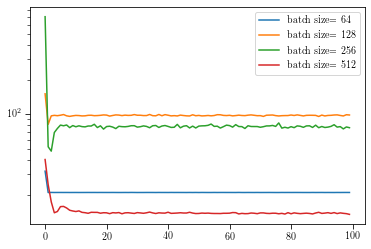

In [35]:
for ii, val in enumerate(dt_loss):

    plt.plot(val, label='batch size= %d' % batch_size[ii]);

plt.yscale('log')
plt.legend();

This was with lr = 0.1, epochs = 25

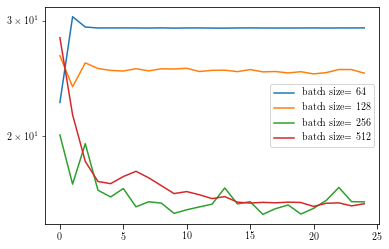

In [33]:
for ii, val in enumerate(dt_loss):

    plt.plot(val, label='batch size= %d' % batch_size[ii]);

plt.yscale('log')
plt.legend();

This was with lr = 0.03, epochs=25

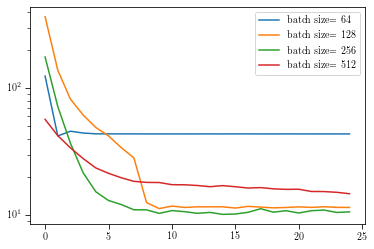

In [31]:
for ii, val in enumerate(dt_loss):

    plt.plot(val, label='batch size= %d' % batch_size[ii]);

plt.yscale('log')
plt.legend();

This was with lr = 0.03, epochs=50

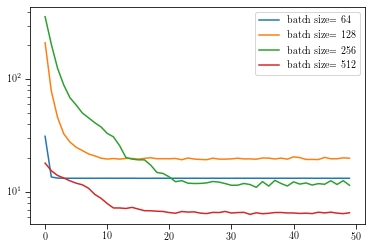

In [29]:
for ii, val in enumerate(dt_loss):

    plt.plot(val, label='batch size= %d' % batch_size[ii]);

plt.yscale('log')
plt.legend();

## 1.2 Grid search on hyperparameters:

In [98]:
pg[0].keys()

dict_keys(['scheduler', 'lr', 'epochs', 'batch_size'])

In [116]:
autoreload.reload(mrpt);

In [129]:
batch_size = [64, 128, 256, 512] # 1024 will cover full stimulus set for most cells (all 2s presentations)
learning_rate = np.geomspace(0.01, 0.15, 4)
epochs = [25, 50, 250]
scheduler = [0, 1]; # off vs. on --> currently, patience is max(8, epochs/10) and factor=0.1

param_grid = {'batch_size': batch_size, 'lr': learning_rate, 'epochs': epochs, 'scheduler': scheduler}
pg = ParameterGrid(param_grid)

pg_loss = np.nan * np.zeros((len(pg), 2)); # [0,1] will be loss and duration of run!

for i,curr_hyper in enumerate(pg):
    if np.mod(i,int(len(pg)/10))==0:
        print('hyper. set %d of %d' % (i, len(pg)));
        
    fit, details = mrpt.setModel(cellNum, expDir, excType, lossType, fitType, lgnFrontOn, 
                                 lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm, trackSteps=1, 
                                 learning_rate=curr_hyper['lr'], batch_size=curr_hyper['batch_size'], 
                                 max_epochs = curr_hyper['epochs'], scheduler=curr_hyper['scheduler'], 
                                 respMeasure=respMeasure, newMethod=1, vecCorrected=0, to_save=False, )
    try:
        pg_loss[i,0] = fit['NLL'];
        pg_loss[i,1] = details['time'][-1][-1] # end time of last epoch!
    except:
        pass

hyper. set 0 of 96
hyper. set 9 of 96
hyper. set 18 of 96
hyper. set 27 of 96
hyper. set 36 of 96
hyper. set 45 of 96
hyper. set 54 of 96
hyper. set 63 of 96
hyper. set 72 of 96
hyper. set 81 of 96
hyper. set 90 of 96


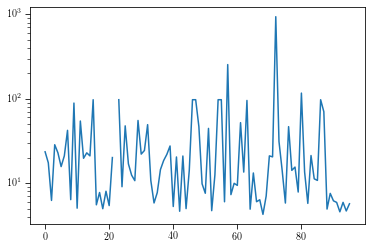

In [131]:
plt.plot(pg_loss[:,0])
plt.yscale('log')

In [140]:
min_arg_of_non_nans = np.argmin(hf.nan_rm(pg_loss[:,0]))
non_nans = np.where(~np.isnan(pg_loss[:,0]))[0]

In [144]:
np.where([x['epochs']==250 for x in pg])

(array([16, 17, 18, 19, 20, 21, 22, 23, 40, 41, 42, 43, 44, 45, 46, 47, 64,
        65, 66, 67, 68, 69, 70, 71, 88, 89, 90, 91, 92, 93, 94, 95]),)

In [145]:
non_nans[min_arg_of_non_nans]

68

In [149]:
[print('%d: %.3f, %s' % (x, pg_loss[x,0], str(pg[x]))) for x in range(64,74)]

64: 4.913, {'scheduler': 0, 'lr': 0.01, 'epochs': 250, 'batch_size': 256}
65: 13.196, {'scheduler': 1, 'lr': 0.01, 'epochs': 250, 'batch_size': 256}
66: 6.023, {'scheduler': 0, 'lr': 0.0246621207433047, 'epochs': 250, 'batch_size': 256}
67: 6.353, {'scheduler': 1, 'lr': 0.0246621207433047, 'epochs': 250, 'batch_size': 256}
68: 4.264, {'scheduler': 0, 'lr': 0.06082201995573401, 'epochs': 250, 'batch_size': 256}
69: 7.026, {'scheduler': 1, 'lr': 0.06082201995573401, 'epochs': 250, 'batch_size': 256}
70: 21.053, {'scheduler': 0, 'lr': 0.15, 'epochs': 250, 'batch_size': 256}
71: 20.483, {'scheduler': 1, 'lr': 0.15, 'epochs': 250, 'batch_size': 256}
72: 940.029, {'scheduler': 0, 'lr': 0.01, 'epochs': 25, 'batch_size': 512}
73: 31.217, {'scheduler': 1, 'lr': 0.01, 'epochs': 25, 'batch_size': 512}


[None, None, None, None, None, None, None, None, None, None]

In [153]:
[print('%d: %.3f, %s' % (x, pg_loss[x,0], str(pg[x]))) for x in non_nans[np.argsort(pg_loss[non_nans,0])]]

68: 4.264, {'scheduler': 0, 'lr': 0.06082201995573401, 'epochs': 250, 'batch_size': 256}
92: 4.572, {'scheduler': 0, 'lr': 0.06082201995573401, 'epochs': 250, 'batch_size': 512}
42: 4.643, {'scheduler': 0, 'lr': 0.0246621207433047, 'epochs': 250, 'batch_size': 128}
94: 4.680, {'scheduler': 0, 'lr': 0.15, 'epochs': 250, 'batch_size': 512}
52: 4.717, {'scheduler': 0, 'lr': 0.06082201995573401, 'epochs': 25, 'batch_size': 256}
64: 4.913, {'scheduler': 0, 'lr': 0.01, 'epochs': 250, 'batch_size': 256}
88: 4.929, {'scheduler': 0, 'lr': 0.01, 'epochs': 250, 'batch_size': 512}
18: 4.976, {'scheduler': 0, 'lr': 0.0246621207433047, 'epochs': 250, 'batch_size': 64}
44: 4.989, {'scheduler': 0, 'lr': 0.06082201995573401, 'epochs': 250, 'batch_size': 128}
10: 5.050, {'scheduler': 0, 'lr': 0.0246621207433047, 'epochs': 50, 'batch_size': 64}
40: 5.286, {'scheduler': 0, 'lr': 0.01, 'epochs': 250, 'batch_size': 128}
20: 5.421, {'scheduler': 0, 'lr': 0.06082201995573401, 'epochs': 250, 'batch_size': 64}


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [156]:
overall_hyper = dict();
overall_hyper['loss'] = pg_loss[:,0]
overall_hyper['time'] = pg_loss[:,1]
overall_hyper['hyper_params'] = pg;

In [164]:
# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
np.save(save_loc + 'hyper_tuning_v1_040.npy', overall_hyper)

#### Try the grid search again!
More focused parameters and with varExpl (i.e. are those loss values reasonable at all?)
Also, use altExp/4 rather than V1/40

In [268]:
cellNum = 4
expDir = 'altExp/'
respMeasure = 0; # dc [0] or f1 [1]

excType = 2; # 1 is deriv. order, 2 is flex. gauss
lossType = 1
fitType = 1 # flat [1], tuned [2] or gain tuned[5]
lgnFrontOn = 1
lgnConType = 1
_LGNforNorm = 0

### Load data (to use for vExp calc.)
data_loc = base_dir + '%sstructures/' % expDir
expName = hf.get_datalist(expDir, force_full=True);
dataList = hf.np_smart_load(str(data_loc + expName))
expInd   = hf.exp_name_to_ind(dataList['expType'][cellNum-1]);

expData = hf.np_smart_load(data_loc + '%s_sfm.npy' % dataList['unitName'][cellNum-1])
trialInf = expData['sfm']['exp']['trial']
dw = mrpt.dataWrapper(trialInf, respMeasure=respMeasure, expInd=expInd)

spikes_rate = hf.get_adjusted_spikerate(expData['sfm']['exp']['trial'], cellNum, expInd, data_loc, rvcName=None, force_dc=True, baseline_sub=False)
_, _, expByCond, _ = hf.organize_resp(spikes_rate, trialInf, expInd);


/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5145: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1167: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  spike_times = np.array([trial_inf['spikeTimes'][x] for x in all_trs]);


In [2302]:
### IMPORTANT: Helper function to assist in calculating vExp
def get_vExp_mod(resps_org, model, dw, expInd, sigmoidSigma=5, respMeasure=respMeasure, returnAll=False, recenter_norm=1):

    # get model response
    mod_resps = model.forward(dw.trInf, respMeasure=respMeasure, 
                              sigmoidSigma=sigmoidSigma, recenter_norm=recenter_norm).detach().numpy()
    
    stimDur = hf.get_exp_params(expInd).stimDur;
    divFactor = stimDur if respMeasure == 0 else 1;
    nTrialsFull = len(trialInf['num']);
    mod_resps_all = np.nan * np.zeros((nTrialsFull, ));
    if respMeasure == 1:
        blanks = np.where(dw.trInf['con'].detach().numpy()==0);
        mod_resps[blanks] = 1e-6;
        mod_resps = np.sum(mod_resps, axis=1);
    mod_resps_all[dw.trInf['num']] = mod_resps;
    _, _, modByCond, _ = hf.organize_resp(np.divide(mod_resps_all, divFactor), trialInf, expInd, respsAsRate=True);
    
    nDisp, nSf, nCon = resps_org.shape;
    vExp = np.nan * np.zeros((nDisp, nCon));
    for dI in np.arange(nDisp):
        for cI in np.arange(nCon):
            vExp[dI, cI] = hf.var_explained(hf.nan_rm(resps_org[dI, :, cI]), hf.nan_rm(modByCond[dI, :, cI]), None);

    if returnAll:
        return np.nanmean(vExp), vExp, modByCond;
    else:
        return np.nanmean(vExp)

In [2303]:
autoreload.reload(mrpt)

<module 'model_responses_pytorch' from '/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/model_responses_pytorch.py'>

In [478]:
verb = False # verbose?

batch_size = [128, 256, 1024] # 1024 will cover full stimulus set for most cells (all 2s presentations)
# learning_rate = np.geomspace(0.05, 0.5, 4) # bad?
learning_rate = np.geomspace(0.01, 0.15, 4) # good?
epochs = [50, 200, 500]
scheduler = [0,1]; # off [0] vs. on [1] --> currently, patience is max(8, epochs/10) and factor=0.1

param_grid = {'batch_size': batch_size, 'lr': learning_rate, 'epochs': epochs, 'scheduler': scheduler}
pg = ParameterGrid(param_grid)

pg_loss = np.nan * np.zeros((len(pg), 3)); # [0,1,2] will be loss,vExp, and duration of run!

for i,curr_hyper in enumerate(pg):
    if np.mod(i,int(len(pg)/10))==0:
        print('hyper. set %d of %d' % (i, len(pg)));
        
    fit, details = mrpt.setModel(cellNum, expDir, excType, lossType, fitType, lgnFrontOn, 
                                 lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm, trackSteps=1, 
                                 learning_rate=curr_hyper['lr'], batch_size=curr_hyper['batch_size'], 
                                 max_epochs = curr_hyper['epochs'], scheduler=curr_hyper['scheduler'], 
                                 respMeasure=respMeasure, newMethod=1, vecCorrected=0, to_save=False, verbose=verb)
    try:
        pg_loss[i,0] = fit['NLL'];
        # INITIAL
        init_mod = mrpt.sfNormMod(fit['opt']['init_params'], expInd, excType, fitType, lossType, lgnFrontOn, newMethod=1, 
                          lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm)
        _, vExp_init, mod_resps_init = get_vExp_mod(expByCond, init_mod, dw, expInd, returnAll=True)

        # CURRENT/FINAL
        curr_prms = fit['params']
        curr_mod = mrpt.sfNormMod(curr_prms, expInd, excType, fitType, lossType, lgnFrontOn, newMethod=1, 
                          lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm)
        _, vExp_all, mod_resps_out = get_vExp_mod(expByCond, curr_mod, dw, expInd, returnAll=True)
        print('vExp: %.2f (was %.2f)' % (vExp_all[0,-1], vExp_init[0,-1])) # high con..
        pg_loss[i,1] = vExp_all[0,-1]
        print(hf.nan_rm(mod_resps_out[0,:,-1]))
        print('Final ^^^....vvv initial\n')
        print(hf.nan_rm(mod_resps_init[0,:,-1]))
        
        pg_loss[i,2] = details['time'][-1][-1] # end time of last epoch!
    except:
        pass

hyper. set 0 of 72
vExp: 89.12 (was -692.57)
[2.54769531e+01 4.34907421e+01 6.52154251e+01 9.28760254e+01
 1.26378363e+02 1.55255769e+02 1.56722743e+02 1.36912898e+02
 8.95242859e+01 1.68407743e+01 1.00000070e-05]
Final ^^^....vvv initial

[178.56426086 215.44952698 242.32009888 265.26733093 287.91379089
 295.17316589 258.39064636 195.51949158 109.13625412  52.11618538
  13.6262723 ]
vExp: 8.74 (was -154.77)
[63.2035183  74.30796509 82.77555313 82.2021492  75.38256989 69.76986542
 63.87210579 55.50950508 40.78999176 29.44398956 22.61284733]
Final ^^^....vvv initial

[7.91807985e+00 1.04640007e+01 1.24976565e+01 1.39994425e+01
 1.57355843e+01 1.64989739e+01 1.43558891e+01 1.00881633e+01
 4.64269438e+00 8.18972629e-01 1.00000070e-05]
vExp: 58.46 (was -134.64)
[ 42.70127831  52.06599579  70.28764496 100.24880295 143.69430847
 185.41138    191.26932831 166.69159088  68.80368729  39.07147217
  39.07147217]
Final ^^^....vvv initial

[16.09694281 16.35555191 16.57799053 16.8063652  17.0359302

vExp: 52.11 (was -42.93)
[ 56.38975143  76.1679985   96.96823959 118.45303116 138.72023926
 146.71122589 129.87695618 105.87016678  78.91426544  55.01749496
  30.94946918]
Final ^^^....vvv initial

[23.39619751 30.96038761 37.19304352 42.93940048 47.57221146 47.97243195
 40.73570557 31.29351311 20.74550915 10.67578316  1.40296088]
vExp: 82.18 (was -34.52)
[ 26.01122589  38.90895195  58.70094643  87.81462021 127.07680817
 165.51660614 177.67300568 169.16255035  88.83714142  16.28768005
  14.43901062]
Final ^^^....vvv initial

[7.97470978e+01 1.06417148e+02 1.32469852e+02 1.58511366e+02
 1.87333276e+02 2.02706775e+02 1.82356735e+02 1.35637286e+02
 7.15863731e+01 2.06391760e+01 1.00000070e-05]
vExp: -23.17 (was 7.94)
[ 22.06967373  24.68426609  36.34495659  74.34324417 162.60665741
 265.71567993 238.66912994 111.85096893  40.26715698  25.67785473
  22.35431538]
Final ^^^....vvv initial

[41.65652809 45.21938438 50.41555328 57.28765793 65.15763016 68.95614395
 62.04315071 49.82705231 40.74

vExp: 73.94 (was -5470.81)
[ 19.30841618  45.65371971  74.72376328 104.50500107 132.2626152
 150.75008698 144.69077988 124.84176483  89.40417862  55.58854294
  21.99729424]
Final ^^^....vvv initial

[146.21612091 281.67464294 441.28082581 499.47362671 532.09837646
 643.67554321 715.55559692 559.71381836 323.0078186  177.7329895
  76.20310974]
vExp: 57.00 (was -81.34)
[ 15.45615911  30.03489475  55.70623207  84.0788002  122.87742996
 181.69078369 222.41248474 176.20516663  82.2664238   29.16278133
  11.31699114]
Final ^^^....vvv initial

[1.00000070e-05 1.00000070e-05 3.51883612e+00 3.87530922e+01
 8.47122536e+01 1.50655344e+02 2.27109402e+02 2.55441621e+02
 1.87392027e+02 9.54864906e+01 1.82865290e+01]
vExp: 80.05 (was -94.52)
[ 18.39321022  31.89294739  56.44104996  90.20957108 123.53213882
 140.21094055 126.61685181  92.32688217  52.12292747  24.97581024
  12.91791382]
Final ^^^....vvv initial

[1.00000070e-05 1.00000070e-05 1.00000070e-05 1.66607046e+01
 7.93677071e+01 1.93074269e+0

In [487]:
min_arg_of_non_nans = np.argmin(hf.nan_rm(pg_loss[:,0]))
non_nans = np.where(~np.isnan(pg_loss[:,0]))[0]

In [489]:
[print('%d: %.3f [vExp=%.2f], %s' % (x, pg_loss[x,0], pg_loss[x,1], str(pg[x]))) for x in non_nans[np.argsort(pg_loss[non_nans,0])]]

58: 1.450 [vExp=91.48], {'scheduler': 0, 'lr': 0.0246621207433047, 'epochs': 200, 'batch_size': 1024}
66: 1.454 [vExp=92.34], {'scheduler': 0, 'lr': 0.0246621207433047, 'epochs': 500, 'batch_size': 1024}
71: 1.567 [vExp=94.42], {'scheduler': 1, 'lr': 0.15, 'epochs': 500, 'batch_size': 1024}
40: 1.568 [vExp=92.85], {'scheduler': 0, 'lr': 0.01, 'epochs': 500, 'batch_size': 256}
43: 1.583 [vExp=90.41], {'scheduler': 1, 'lr': 0.0246621207433047, 'epochs': 500, 'batch_size': 256}
56: 1.585 [vExp=83.36], {'scheduler': 0, 'lr': 0.01, 'epochs': 200, 'batch_size': 1024}
41: 1.682 [vExp=79.93], {'scheduler': 1, 'lr': 0.01, 'epochs': 500, 'batch_size': 256}
67: 1.711 [vExp=80.17], {'scheduler': 1, 'lr': 0.0246621207433047, 'epochs': 500, 'batch_size': 1024}
34: 1.719 [vExp=96.52], {'scheduler': 0, 'lr': 0.0246621207433047, 'epochs': 200, 'batch_size': 256}
32: 1.724 [vExp=96.72], {'scheduler': 0, 'lr': 0.01, 'epochs': 200, 'batch_size': 256}
54: 1.728 [vExp=95.26], {'scheduler': 0, 'lr': 0.15, 'e

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [490]:
overall_hyper = dict();
overall_hyper['loss'] = pg_loss[:,0]
overall_hyper['vExp_hiCon'] = pg_loss[:,1]
overall_hyper['time'] = pg_loss[:,2]
overall_hyper['hyper_params'] = pg;

In [491]:
# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
np.save(save_loc + 'hyper_tuning_altExp_004.npy', overall_hyper)

## 1.3 Need to improve initialization!
It seems that our model starts off with parameters that give an entirely flat response - and thus the model first gets the right response amplitude before shaping the frequency tuning. We _should_ start with something that gives us tuning to begin with.

altExp/4, weighted gain control has a good fit, so let's explore the model using those parameters

In [482]:
# flName  = 'fitListHPC_pyt_221005_LGN_flat_sqrt.npy';
flName  = 'fitListHPC_pyt_221005_LGN_wght_sqrt.npy';
expDir  = 'altExp/'
cellNum = 4;

excType = 2; # 1 is deriv. order, 2 is flex. gauss
lossType = 1
fitType = 2 # flat [1], tuned [2] or gain tuned[5]
lgnFrontOn = 1
lgnConType = 1
_LGNforNorm = 0

In [483]:
fit = hf.np_smart_load('%s%s' % (data_loc, flName))
fit_curr = fit[cellNum-1]['dc'];
pms = fit_curr['params']

In [484]:
fit_curr['opt'].keys()

dict_keys(['call', 'epochs', 'batch_size', 'learning_rate', 'shuffle', 'dropLast'])

#### Explorations of influence of various parameters

In [485]:
autoreload.reload(mrpt);

##### respExp

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5145: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1893: RuntimeWarning: invalid value encountered in double_scalars
  resp_dist = lambda x, y: np.sum(np.square(x-y))/np.maximum(len(x), len(y))
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5145: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarn

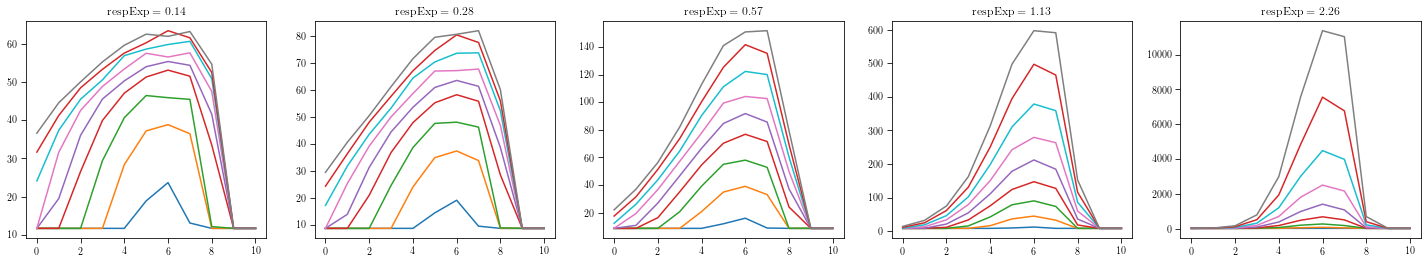

In [453]:
rE = np.geomspace(0.25, 4, 5) * pms[3]
nplt = len(rE);

f, ax = plt.subplots(nrows=1, ncols=nplt, figsize=(5*nplt,4));

for i, respExp in enumerate(rE):
    pms_copy = np.copy(pms);
    pms_copy[3] = respExp

    oy_mod = mrpt.sfNormMod(pms_copy, expInd, excType, fitType, lossType, lgnFrontOn, newMethod=1, 
                              lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm)
    _, vExp_init, mod_resps_init = get_vExp_mod(expByCond, oy_mod, dw, expInd, returnAll=True)
    
    
    [ax[i].plot(hf.nan_rm(x)) for x in np.transpose(mod_resps_init[0])]
    ax[i].set_title('respExp = %.2f' % (respExp))


##### Sigma

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5145: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1893: RuntimeWarning: invalid value encountered in double_scalars
  resp_dist = lambda x, y: np.sum(np.square(x-y))/np.maximum(len(x), len(y))
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5145: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarn

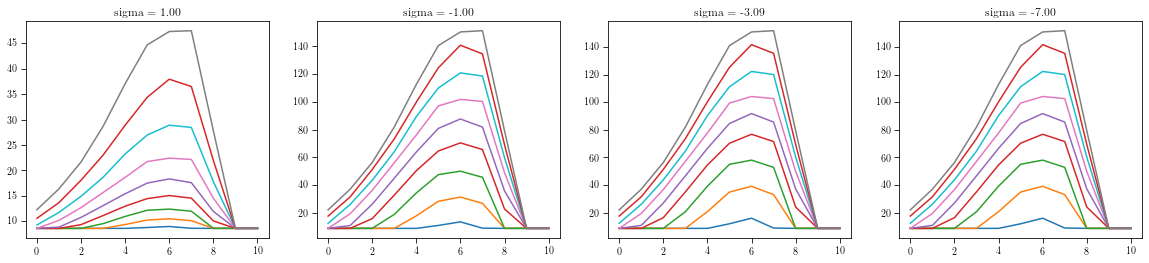

In [461]:
sigmas = [1, -1, pms[2], -7]
nplt = len(sigmas);

f, ax = plt.subplots(nrows=1, ncols=nplt, figsize=(5*nplt,4));

for i, sig in enumerate(sigmas):
    pms_copy = np.copy(pms);
    pms_copy[2] = sig

    oy_mod = mrpt.sfNormMod(pms_copy, expInd, excType, fitType, lossType, lgnFrontOn, newMethod=1, 
                              lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm)
    _, vExp_init, mod_resps_init = get_vExp_mod(expByCond, oy_mod, dw, expInd, returnAll=True)
    
    
    [ax[i].plot(hf.nan_rm(x)) for x in np.transpose(mod_resps_init[0])]
    ax[i].set_title('sigma = %.2f' % (sig))


##### Resp scalar

In [463]:
pms[4]

-2.6554923057556152

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:4844: RuntimeWarning: invalid value encountered in multiply
  modRespOrg = np.nan * np.empty((nDisps, nSfs, nCons, nRepsMax));
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5145: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1893: RuntimeWarning: invalid value encountered in double_scalars
  resp_dist = lambda x, y: np.sum(np.square(x-y))/np.maximum(len(x), len(y))
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns

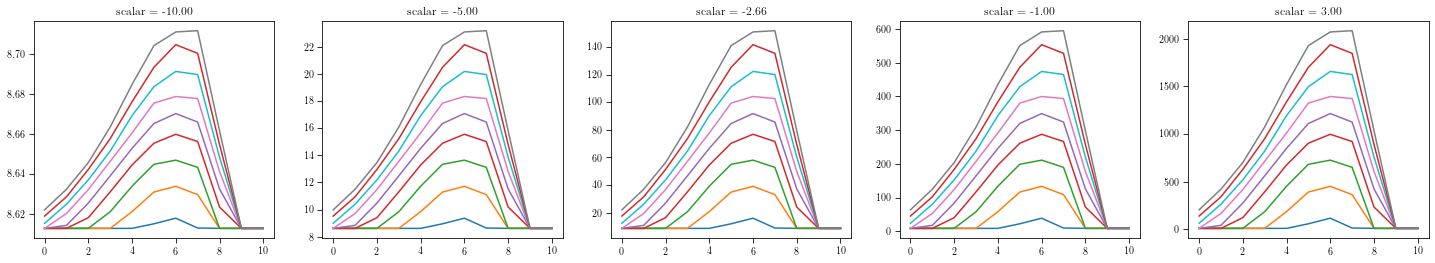

In [464]:
scalars = [-10, -5, pms[4], -1, 3]
nplt = len(scalars);

f, ax = plt.subplots(nrows=1, ncols=nplt, figsize=(5*nplt,4));

for i, scl in enumerate(scalars):
    pms_copy = np.copy(pms);
    pms_copy[4] = scl

    oy_mod = mrpt.sfNormMod(pms_copy, expInd, excType, fitType, lossType, lgnFrontOn, newMethod=1, 
                              lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm)
    _, vExp_init, mod_resps_init = get_vExp_mod(expByCond, oy_mod, dw, expInd, returnAll=True)
    
    
    [ax[i].plot(hf.nan_rm(x)) for x in np.transpose(mod_resps_init[0])]
    ax[i].set_title('scalar = %.2f' % (scl))


##### Noise early

In [465]:
pms[5]

-0.09994937479496002

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5145: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1893: RuntimeWarning: invalid value encountered in double_scalars
  resp_dist = lambda x, y: np.sum(np.square(x-y))/np.maximum(len(x), len(y))
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5145: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarn

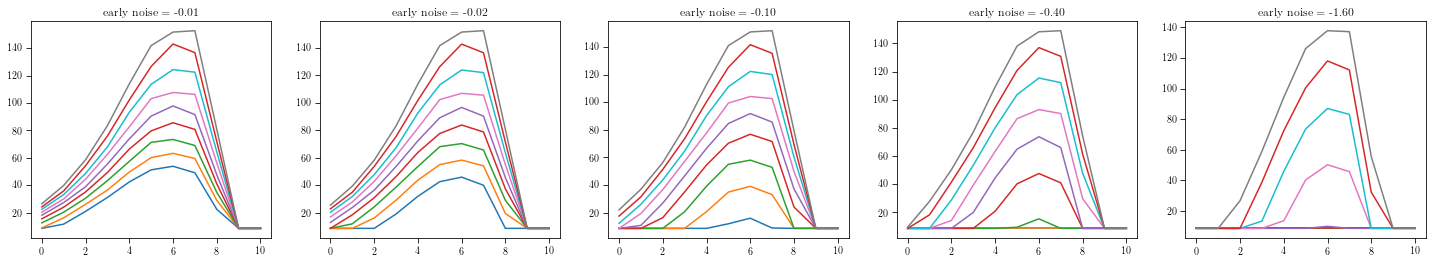

In [468]:
noise_e = np.geomspace(1/16, 16, 5) * pms[5]
nplt = len(noise_e);

f, ax = plt.subplots(nrows=1, ncols=nplt, figsize=(5*nplt,4));

for i, nse in enumerate(noise_e):
    pms_copy = np.copy(pms);
    pms_copy[5] = nse

    oy_mod = mrpt.sfNormMod(pms_copy, expInd, excType, fitType, lossType, lgnFrontOn, newMethod=1, 
                              lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm)
    _, vExp_init, mod_resps_init = get_vExp_mod(expByCond, oy_mod, dw, expInd, returnAll=True)
    
    
    [ax[i].plot(hf.nan_rm(x)) for x in np.transpose(mod_resps_init[0])]
    ax[i].set_title('early noise = %.2f' % (nse))


##### Noise late

Serves as a response floor (i.e. baseline)

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5145: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1893: RuntimeWarning: invalid value encountered in double_scalars
  resp_dist = lambda x, y: np.sum(np.square(x-y))/np.maximum(len(x), len(y))
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5145: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarn

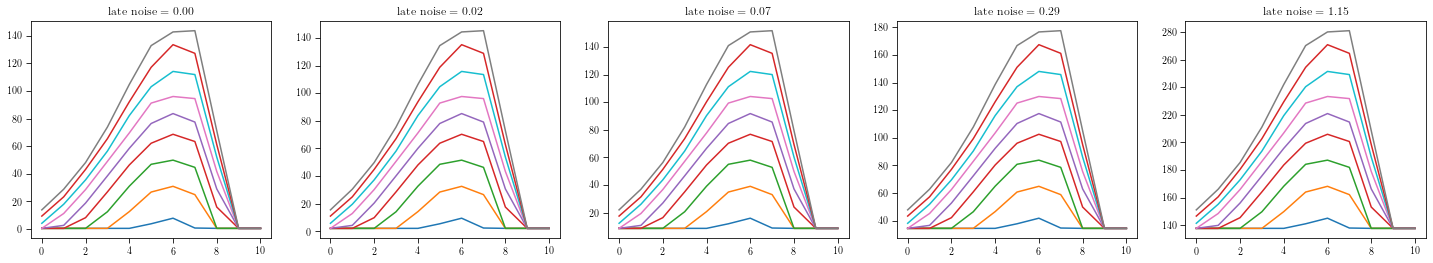

In [471]:
noise_l = np.geomspace(1/16, 16, 5) * pms[6]
nplt = len(noise_l);

f, ax = plt.subplots(nrows=1, ncols=nplt, figsize=(5*nplt,4));

for i, nsl in enumerate(noise_l):
    pms_copy = np.copy(pms);
    pms_copy[6] = nsl

    oy_mod = mrpt.sfNormMod(pms_copy, expInd, excType, fitType, lossType, lgnFrontOn, newMethod=1, 
                              lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm)
    _, vExp_init, mod_resps_init = get_vExp_mod(expByCond, oy_mod, dw, expInd, returnAll=True)
    
    
    [ax[i].plot(hf.nan_rm(x)) for x in np.transpose(mod_resps_init[0])]
    ax[i].set_title('late noise = %.2f' % (nsl))


##### magno weight

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5145: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1893: RuntimeWarning: invalid value encountered in double_scalars
  resp_dist = lambda x, y: np.sum(np.square(x-y))/np.maximum(len(x), len(y))
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5145: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarn

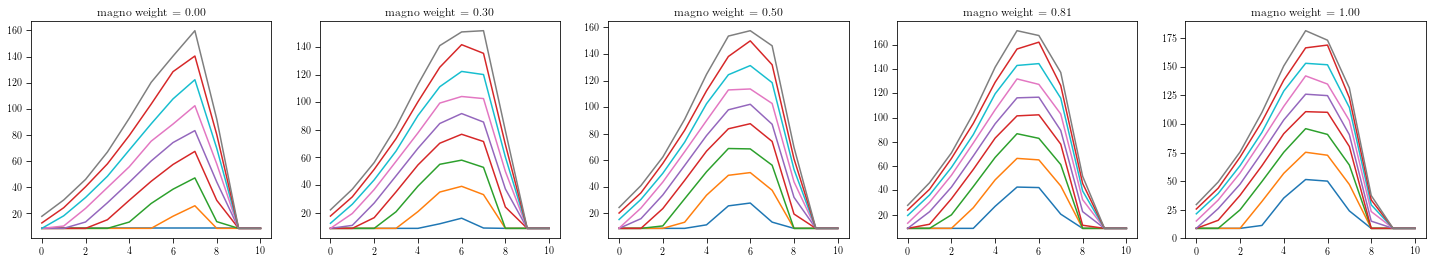

In [475]:
mWts = [-10, pms[-1], 0, -pms[1], 10]
nplt = len(mWts);

f, ax = plt.subplots(nrows=1, ncols=nplt, figsize=(5*nplt,4));

for i, mWt in enumerate(mWts):
    pms_copy = np.copy(pms);
    pms_copy[-1] = mWt

    oy_mod = mrpt.sfNormMod(pms_copy, expInd, excType, fitType, lossType, lgnFrontOn, newMethod=1, 
                              lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm)
    _, vExp_init, mod_resps_init = get_vExp_mod(expByCond, oy_mod, dw, expInd, returnAll=True)
    
    
    [ax[i].plot(hf.nan_rm(x)) for x in np.transpose(mod_resps_init[0])]
    ax[i].set_title('magno weight = %.2f' % (hf.sigmoid(mWt)))


## 1.4 Do the optimization in scipy!

We've already made changes to the model in pytorch that would be time-consuming to replicate outside of pytorch. However, while we still workout the best set of hyperparameters, let's instead do the optimization in scipy.

All we have to is write a wrapper objection function that will just run the model in pytorch and then "detach" the results in numpy!


In [522]:
autoreload.reload(mrpt);

In [615]:
### Load the trialInf
data_loc = base_dir + '%sstructures/' % expDir
expName = hf.get_datalist(expDir, force_full=True);
dataList = hf.np_smart_load(str(data_loc + expName))
expInd   = hf.exp_name_to_ind(dataList['expType'][cellNum-1]);

expData = hf.np_smart_load(data_loc + '%s_sfm.npy' % dataList['unitName'][cellNum-1])
trialInf = expData['sfm']['exp']['trial']
dw = mrpt.dataWrapper(trialInf, respMeasure=respMeasure, expInd=expInd)

### Set up the model and the dataWrapper
init_prms = mrpt.setModel(4, expDir=expDir, excType=excType, lossType=lossType, fitType=fitType, 
                          lgnFrontEnd=lgnFrontOn, lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm,
                          fixRespExp=fixRespExp, respMeasure=0, 
                          newMethod=1, vecCorrected=0, initFromCurr=0, returnOnlyInits=True)
    
def obj(prms, loss_type=1, dw=dw, respMeasure=0, _sigmoidSigma=5, lgnType=1,
        newMethod=1, vecCorrected=0, normType=1, excType=2, lgnCon=1, _applyLGNtoNorm=0, debug=False):
    
    # set up the model and process the data (incl. responses)
    mod = mrpt.sfNormMod(prms, expInd=expInd, excType=excType, normType=normType, lossType=lossType,  
                         newMethod=newMethod, lgnFrontEnd=lgnType, lgnConType=lgnCon, applyLGNtoNorm=_applyLGNtoNorm)
    trInfTemp, respData = mrpt.process_data(trialInf, expInd, respMeasure) # respOverwrite=respOverwrite
    # then get the model response
    modResp = mod.forward(trInfTemp, respMeasure=respMeasure, sigmoidSigma=_sigmoidSigma).detach().numpy()
    # compute the loss!
    ls =  mrpt.loss_sfNormMod(mrpt._cast_as_tensor(modResp.flatten()), mrpt._cast_as_tensor(respData.flatten()), lossType=loss_type).detach().numpy()
    
    if debug:
        return ls, modResp, respData
    else:
        return ls


FitList: fitList_pyt_221005_noRE_LGN_wght_sqrt.npy [expDir is altExp/]
loading data structure from /arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/altExp/structures/...
expInd is 2
respMeasure, vecCorrected: 0, 0

********MODEL PARAMETERS********
prefSf: 1.26
sigma l|r: -0.09|-0.97
mWeight: 0.35 (orig -0.62)
scalar|early|late: 0.586|-0.204|-0.370
norm. const.: -2.00
tuned norm mn|std: 1.02|1.98
No LGN for GC
********END OF MODEL PARAMETERS********



In [594]:
good_fit = hf.np_smart_load('altExp/structures/fitListHPC_pyt_221006f_noRE_LGN_flat_sqrt.npy')

In [613]:
good_fit[3]['dc']['NLL']

array(1.8122715, dtype=float32)

In [617]:
import scipy.optimize as opt

In [631]:
init_prms = mrpt.setModel(4, expDir=expDir, excType=excType, lossType=lossType, fitType=fitType, 
                          lgnFrontEnd=lgnFrontOn, lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm,
                          fixRespExp=fixRespExp, respMeasure=0, 
                          newMethod=1, vecCorrected=0, initFromCurr=0, returnOnlyInits=True)

# init_prms = good_fit[3]['dc']['params'];

# Adjust as needed below (bounds are not right, ex. for prefSf now that it's a sigmoid...)
# all_bounds = hf.getConstraints(fitType, excType, fixRespExp=1);

to_opt = opt.minimize(obj, init_prms)


FitList: fitList_pyt_221005_noRE_LGN_wght_sqrt.npy [expDir is altExp/]
loading data structure from /arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/altExp/structures/...
expInd is 2
respMeasure, vecCorrected: 0, 0

********MODEL PARAMETERS********
prefSf: 0.65
sigma l|r: 0.08|0.22
mWeight: 0.58 (orig 0.34)
scalar|early|late: 0.011|-0.162|0.379
norm. const.: -2.00
tuned norm mn|std: 0.66|1.78
No LGN for GC
********END OF MODEL PARAMETERS********



In [633]:
ls, modresp, dataresp = obj(init_prms, debug=True)

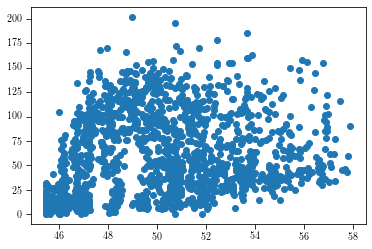

In [635]:
plt.scatter(modresp, dataresp)

### 1.5 Deconstructing the model response
Let's make sure our model is parameterized in the most efficient/effective way, such that the parameters are easy to intialize and understand!

In [2578]:
autoreload.reload(mrpt);

In [741]:
good_prms = good_fit[3]['dc']['params'];

normType=1
excType=2
lgnType=1
lgnCon=1
_applyLGNtoNorm=0
sigmoidSigma = 5
recenter_norm=True

mod = mrpt.sfNormMod(good_prms, expInd=expInd, excType=excType, normType=normType, lossType=lossType,  
                         newMethod=1, lgnFrontEnd=lgnType, lgnConType=lgnCon, applyLGNtoNorm=_applyLGNtoNorm)


trInf, respData = mrpt.process_data(trialInf, expInd, respMeasure=0) # warning: added respOverwrite here; also add whichTrials???   

exc,inh,sigmaFilt = mod.respPerCell(trInf, debug=1, sigmoidSigma=sigmoidSigma, recenter_norm=recenter_norm);
amps, psth_orig = mod.forward(trInf, returnPsth=True)

# detach everything...
exc = exc.detach().numpy();
inh = inh.detach().numpy();
sigmaFilt = sigmaFilt.detach().numpy();
amps = amps.detach().numpy();
psth = psth_orig.detach().numpy();

##### First, check that our non-pytorch FFT calculation returns what we expect
We'll comapre raw spike counts to the PSTH-derived DC

In [799]:
nTr = len(trialInf['spikeTimes'])
cust_spiketimes = np.array([trialInf['spikeTimes'][x] for x in range(nTr)]);
cust_counts = np.array([trialInf['spikeCount'][x] for x in range(nTr)])
cust_psth, cust_bins = hf.make_psth(cust_spiketimes, stimDur=1); 

power, rel_power, full_ft = hf.spike_fft(np.array(cust_psth), stimDur=1)
dcs = [x[0] for x in power];

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


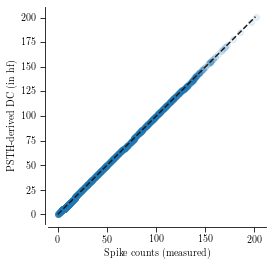

In [800]:
plt.scatter(cust_counts, dcs,alpha=0.1)
plt.axis('scaled');
plt.xlabel('Spike counts (measured)')
plt.ylabel('PSTH-derived DC (in hf)')
mx = np.nanmax(dcs);
plt.plot([0,mx],[0,mx], 'k--');
sns.despine(offset=3)

All good! Now, compare against the pytorch version:

##### Now, checking pytorch FFT calculation:

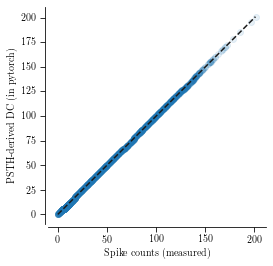

In [810]:
spectrum, rel_amp, full_fourier = mrpt.spike_fft(mrpt._cast_as_tensor([cust_psth]), stimDur=1)
specs = spectrum[0].detach().numpy();
pyt_dcs = np.array([x[0] for x in specs])

plt.scatter(cust_counts, pyt_dcs,alpha=0.1)
plt.axis('scaled');
plt.xlabel('Spike counts (measured)')
plt.ylabel('PSTH-derived DC (in pytorch)')
mx = np.nanmax(dcs);
plt.plot([0,mx],[0,mx], 'k--');
sns.despine(offset=3)

##### And now, look at some example model PSTHs

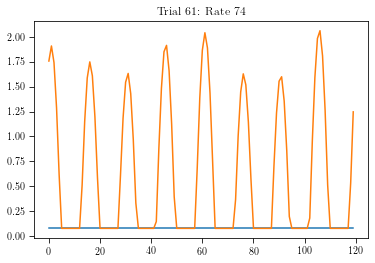

In [824]:
trInd = 5;
plt.plot(psth[trInd])
plt.title('Trial %d: Rate %d' % (trInd, amps[trInd]));

trInd = 61;
plt.plot(psth[trInd])
plt.title('Trial %d: Rate %d' % (trInd, amps[trInd]));

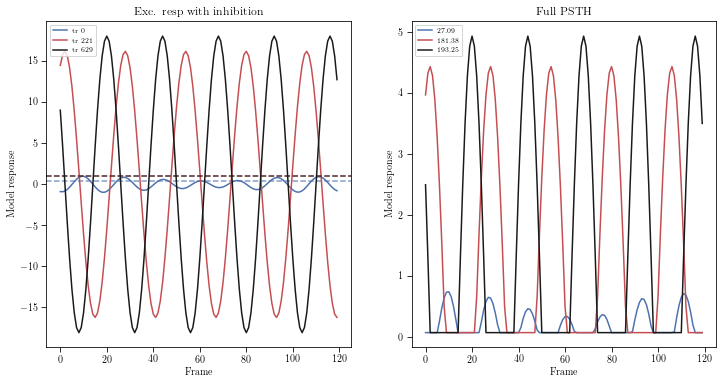

In [729]:
f, ax = plt.subplots(1,2,figsize=(12,6))

ri = np.random.randint(0, exc.shape[-1])
trs = [0, ri, oy];
clrs = ['b','r','k']

for tr,clr in zip(trs, clrs):
    # exc
    ax[0].plot(exc[:,tr], color=clr, label='tr %d' % tr)
    # inh
#     ax[0].plot(0, inh[tr], '>', color='k')
    ax[0].axhline(inh[tr], color=clr, linestyle='--', alpha=0.7)
    # full model
    ax[1].plot(psth[tr], color=clr, label='%.2f' % amps[tr])

ax[0].set_title('Exc. resp with inhibition')
ax[1].set_title('Full PSTH')
for i in range(2):
    # labels
    ax[i].legend(fontsize='x-small');
    ax[i].set_xlabel('Frame')
    ax[i].set_ylabel('Model response');


##### Interlude: Check the normalization weight calculation

In [1416]:
autoreload.reload(mrpt); autoreload.reload(hf);

In [1417]:
good_fit_wt = hf.np_smart_load('altExp/structures/fitListHPC_pyt_221007ff_noRE_noSched_LGN_wght_sqrt.npy')
good_prms_wt = good_fit_wt[3]['dc']['params'];

In [1434]:
cellNum = 40
expDir = 'V1/'
respMeasure = 0; # dc [0] or f1 [1]

excType = 2; # 1 is deriv. order, 2 is flex. gauss
lossType = 1
fitType = 1 # flat [1], tuned [2] or gain tuned[5]
lgnFrontOn = 1
lgnConType = 1
_LGNforNorm = 0

### Load data (to use for vExp calc.)
data_loc = base_dir + '%sstructures/' % expDir
expName = hf.get_datalist(expDir, force_full=True);
dataList = hf.np_smart_load(str(data_loc + expName))
expInd   = hf.exp_name_to_ind(dataList['expType'][cellNum-1]);

if respMeasure == 1:
    rvcName = 'rvcFitsHPC_220928'
    rvcFits = hf.get_rvc_fits(data_loc, expInd, cellNum, rvcName=rvcName, rvcMod=1, direc=1, vecF1=0);
    get_adj_spikes = hf.get_adjusted_spikerate(trialInf, cellNum, expInd, data_loc, rvcName=rvcFits, rvcMod=-1, 
                                               baseline_sub=False, return_measure=False, vecF1=0, force_f1=True, returnByComp=True)

expData = hf.np_smart_load(data_loc + '%s_sfm.npy' % dataList['unitName'][cellNum-1])
trialInf = expData['sfm']['exp']['trial']
respOverwrite = None if respMeasure==0 else get_adj_spikes;
dw = mrpt.dataWrapper(trialInf, respMeasure=respMeasure, expInd=expInd, respOverwrite=respOverwrite)

spikes_rate = hf.get_adjusted_spikerate(expData['sfm']['exp']['trial'], cellNum, expInd, data_loc, rvcName=rvcName, rvcMod=1, force_dc=True if respMeasure==0 else False, baseline_sub=False)
_, _, expByCond, _ = hf.organize_resp(spikes_rate, trialInf, expInd, respsAsRate=False);

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5145: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1167: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  spike_times = np.array([trial_inf['spikeTimes'][x] for x in all_trs]);


In [1456]:
normType = 1; # flat
# normType = 2; # weight
# normType = 5; # weighted gain

# prms_use_orig = np.copy(prms_use);
# prms_use = good_prms if normType==1 else good_prms_wt;

init_prms = mrpt.setModel(cellNum, expDir=expDir, excType=excType, lossType=lossType, fitType=normType, 
                          lgnFrontEnd=lgnFrontOn, lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm,
                          fixRespExp=fixRespExp, respMeasure=respMeasure, normToOne=True,
                          newMethod=1, vecCorrected=0, initFromCurr=0, returnOnlyInits=True)

prms_use = init_prms
# prms_use = prms_use_orig;
# prms_use[5] = 0.01
# prms_use[-3] = 0.4; # larger sigma?

init_mod = mrpt.sfNormMod(prms_use, expInd=expInd, excType=excType, normType=normType, lossType=lossType,  
                         newMethod=1, lgnFrontEnd=lgnType, lgnConType=lgnCon, applyLGNtoNorm=_applyLGNtoNorm,normToOne=True)


# amps, psth_orig = mod.forward(trInf, returnPsth=True)

_, vExp_init, mod_resps_init = get_vExp_mod(expByCond, init_mod, dw, expInd, respMeasure=respMeasure, returnAll=True)



FitList: fitList_pyt_221010ff_noRE_LGN_flat_sqrt.npy [expDir is V1/]
loading data structure from /arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/V1/structures/...
expInd is 5
respMeasure, vecCorrected: 0, 0


/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5145: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);


prefSf: 2.46

********MODEL PARAMETERS********
prefSf: 2.72
sigma l|r: -0.64|-0.00
mWeight: 0.41 (orig -0.35)
scalar|early|late: 204.863|-0.026|8.276
norm. const.: -1.00
No LGN for GC
********END OF MODEL PARAMETERS********



/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1893: RuntimeWarning: invalid value encountered in double_scalars
  resp_dist = lambda x, y: np.sum(np.square(x-y))/np.maximum(len(x), len(y))


##### Plot initial fit:

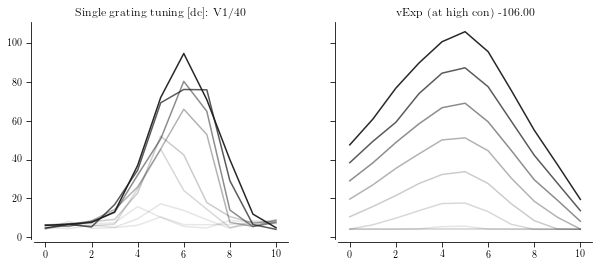

In [1457]:
f, ax = plt.subplots(1,2,figsize=(10,4), sharey=True, sharex=True)

# data
[ax[0].plot(hf.nan_rm(x), color='k', alpha=np.maximum(0.1, i/mod_resps_init.shape[-1])) for i,x in enumerate(np.transpose(expByCond[0]))]
ax[0].set_title('Single grating tuning [%s]: %s/%02d' % ('dc' if respMeasure==0 else 'f1', expDir.replace('/', '').replace('_', ''), cellNum));

# model
[ax[1].plot(hf.nan_rm(x), color='k', alpha=np.maximum(0.1, i/mod_resps_init.shape[-1])) for i,x in enumerate(np.transpose(mod_resps_init[0]))]
ax[1].set_title('vExp (at high con) %.2f' % vExp_init[0,-1]);

sns.despine(offset=3)

##### Explore changes in early noise:

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5145: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1893: RuntimeWarning: invalid value encountered in double_scalars
  resp_dist = lambda x, y: np.sum(np.square(x-y))/np.maximum(len(x), len(y))


KeyboardInterrupt: 

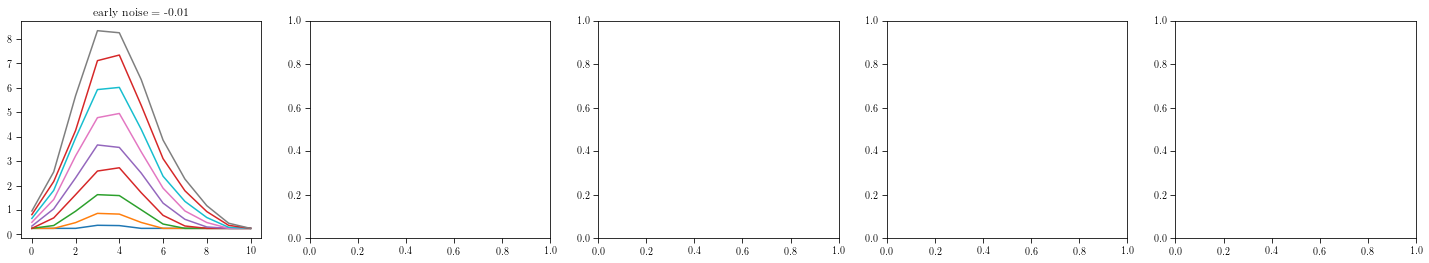

In [1308]:
noise_e = np.geomspace(1/16, 16, 5) * pms[5]
nplt = len(noise_e);

f, ax = plt.subplots(nrows=1, ncols=nplt, figsize=(5*nplt,4));

for i, nse in enumerate(noise_e):
    pms_copy = np.copy(init_prms);
    pms_copy[5] = nse

    oy_mod = mrpt.sfNormMod(pms_copy, expInd, excType, fitType, lossType, lgnFrontOn, newMethod=1, 
                              lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm)
    _, vExp_init, mod_resps_init = get_vExp_mod(expByCond, oy_mod, dw, expInd, returnAll=True)
    
    
    [ax[i].plot(hf.nan_rm(x)) for x in np.transpose(mod_resps_init[0])]
    ax[i].set_title('early noise = %.2f' % (nse))


##### Explore changes in sigma:

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5145: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1893: RuntimeWarning: invalid value encountered in double_scalars
  resp_dist = lambda x, y: np.sum(np.square(x-y))/np.maximum(len(x), len(y))
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5145: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarn

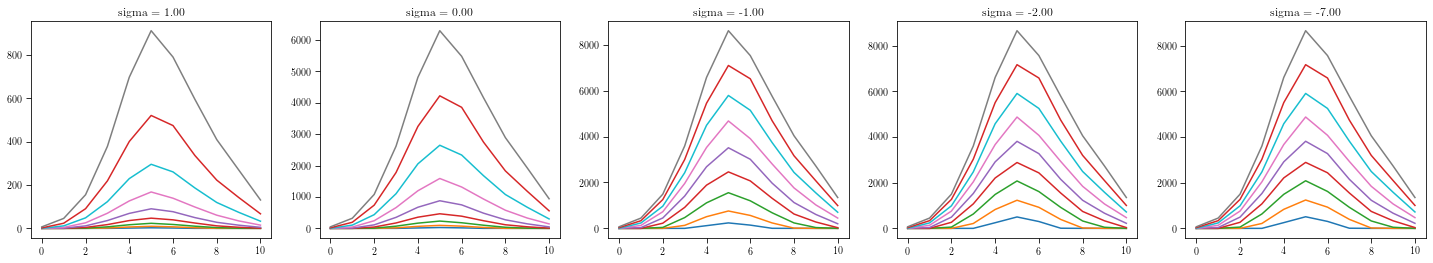

In [988]:
sigmas = [1, 0, -1, init_prms[2], -7]
nplt = len(sigmas);

f, ax = plt.subplots(nrows=1, ncols=nplt, figsize=(5*nplt,4));

for i, sig in enumerate(sigmas):
    pms_copy = np.copy(init_prms);
    pms_copy[2] = sig

    oy_mod = mrpt.sfNormMod(pms_copy, expInd, excType, fitType, lossType, lgnFrontOn, newMethod=1, 
                              lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm)
    _, vExp_init, mod_resps_init = get_vExp_mod(expByCond, oy_mod, dw, expInd, returnAll=True)
    
    
    [ax[i].plot(hf.nan_rm(x)) for x in np.transpose(mod_resps_init[0])]
    ax[i].set_title('sigma = %.2f' % (sig))


In [ ]:
verb = False # verbose?

batch_size = [128, 256, 1024] # 1024 will cover full stimulus set for most cells (all 2s presentations)
# learning_rate = np.geomspace(0.05, 0.5, 4) # bad?
learning_rate = np.geomspace(0.01, 0.15, 4) # good?
epochs = [50, 200, 500]
scheduler = [0,1]; # off [0] vs. on [1] --> currently, patience is max(8, epochs/10) and factor=0.1

param_grid = {'batch_size': batch_size, 'lr': learning_rate, 'epochs': epochs, 'scheduler': scheduler}
pg = ParameterGrid(param_grid)

pg_loss = np.nan * np.zeros((len(pg), 3)); # [0,1,2] will be loss,vExp, and duration of run!

for i,curr_hyper in enumerate(pg):
    if np.mod(i,int(len(pg)/10))==0:
        print('hyper. set %d of %d' % (i, len(pg)));
        
    fit, details = mrpt.setModel(cellNum, expDir, excType, lossType, fitType, lgnFrontOn, 
                                 lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm, trackSteps=1, 
                                 learning_rate=curr_hyper['lr'], batch_size=curr_hyper['batch_size'], 
                                 max_epochs = curr_hyper['epochs'], scheduler=curr_hyper['scheduler'], 
                                 respMeasure=respMeasure, newMethod=1, vecCorrected=0, to_save=False, verbose=verb)
    try:
        pg_loss[i,0] = fit['NLL'];
        # INITIAL
        init_mod = mrpt.sfNormMod(fit['opt']['init_params'], expInd, excType, fitType, lossType, lgnFrontOn, newMethod=1, 
                          lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm)
        _, vExp_init, mod_resps_init = get_vExp_mod(expByCond, init_mod, dw, expInd, returnAll=True)

        # CURRENT/FINAL
        curr_prms = fit['params']
        curr_mod = mrpt.sfNormMod(curr_prms, expInd, excType, fitType, lossType, lgnFrontOn, newMethod=1, 
                          lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm)
        _, vExp_all, mod_resps_out = get_vExp_mod(expByCond, curr_mod, dw, expInd, returnAll=True)
        print('vExp: %.2f (was %.2f)' % (vExp_all[0,-1], vExp_init[0,-1])) # high con..
        pg_loss[i,1] = vExp_all[0,-1]
        print(hf.nan_rm(mod_resps_out[0,:,-1]))
        print('Final ^^^....vvv initial\n')
        print(hf.nan_rm(mod_resps_init[0,:,-1]))
        
        pg_loss[i,2] = details['time'][-1][-1] # end time of last epoch!
    except:
        pass

# 2. Exploring flat gain control:
Why is this model still giving frequency specific suppression, per mixture suppression plots? We also explore some other oddities that appear when analyzing responses (e.g. why not perfectly parallel RVCs with no tuned gain control?)

Load the data and a flat gain control model fit:

In [1486]:
expData['unitLabel']

'm670l38'

In [1516]:
cellNum = 4
expDir = 'altExp/'
respMeasure = 0; # dc [0] or f1 [1]

excType = 2; # 1 is deriv. order, 2 is flex. gauss
lossType = 1
fitType = 1 # flat [1], tuned [2] or gain tuned[5]
lgnFrontOn = 0
lgnConType = 1
_LGNforNorm = 0
normToOne = True;
recenter_norm = 2;
_sigmoidSigma = 5;

### Load data (to use for vExp calc.)
data_loc = base_dir + '%sstructures/' % expDir
expName = hf.get_datalist(expDir, force_full=True);
dataList = hf.np_smart_load(str(data_loc + expName))
expInd   = hf.exp_name_to_ind(dataList['expType'][cellNum-1]);

if respMeasure == 1:
    rvcName = 'rvcFitsHPC_220928'
    rvcFits = hf.get_rvc_fits(data_loc, expInd, cellNum, rvcName=rvcName, rvcMod=1, direc=1, vecF1=0);
    get_adj_spikes = hf.get_adjusted_spikerate(trialInf, cellNum, expInd, data_loc, rvcName=rvcFits, rvcMod=-1, 
                                               baseline_sub=False, return_measure=False, vecF1=0, force_f1=True, returnByComp=True)

expData = hf.np_smart_load(data_loc + '%s_sfm.npy' % dataList['unitName'][cellNum-1])
trialInf = expData['sfm']['exp']['trial']
respOverwrite = None if respMeasure==0 else get_adj_spikes;
dw = mrpt.dataWrapper(trialInf, respMeasure=respMeasure, expInd=expInd, respOverwrite=respOverwrite)

In [1525]:
good_fit = hf.np_smart_load('%sstructures/fitListHPC_pyt_221013_noRE_noSched_flat_sqrt.npy' % expDir)
respStr = 'dc' if respMeasure == 0 else 'f1'
mod_prms = good_fit[cellNum-1][respStr]['params']

In [1589]:
# get the stimVals
_, stimVals, val_con_by_disp, val_by_stim_val, _ = hf.tabulate_responses(expData, expInd);
disps,cons,sfs = stimVals;

Now, get the model response:

In [1526]:
def gather_into_full_resp(dw, trialInf, expInd, mod_resps):
    
    stimDur = hf.get_exp_params(expInd).stimDur;
    divFactor = stimDur if respMeasure == 0 else 1;
    nTrialsFull = len(trialInf['num']);
    mod_resps_all = np.nan * np.zeros((nTrialsFull, ));
    if respMeasure == 1:
        blanks = np.where(dw.trInf['con'].detach().numpy()==0);
        mod_resps[blanks] = 1e-6;
        mod_resps = np.sum(mod_resps, axis=1);
    mod_resps_all[dw.trInf['num']] = mod_resps;
    _, _, modByCond, _ = hf.organize_resp(np.divide(mod_resps_all, divFactor), trialInf, expInd, respsAsRate=True);
    
    return modByCond;

In [2014]:
autoreload.reload(mrpt);
autoreload.reload(hf);
autoreload.reload(psf);

In [2015]:
model = mrpt.sfNormMod(mod_prms, expInd=expInd, excType=excType, normType=fitType, 
                       lossType=lossType, lgnFrontEnd=lgnFrontOn, newMethod=1, 
                       lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm, normToOne=normToOne)

modResp = model.forward(dw.trInf, respMeasure=respMeasure, sigmoidSigma=_sigmoidSigma, recenter_norm=recenter_norm).detach().numpy();
oy = gather_into_full_resp(dw, trialInf, expInd, modResp);

resps = psf.get_model_responses(trialInf, good_fit, expInd, cellNum, excType, fitType, f1f0_rat=None, respMeasure=respMeasure,
                                baseline=None, lossType=lossType, lgnFrontEnd=lgnFrontOn, lgnConType=lgnConType)

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5146: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);


In [2016]:
measured, _, pred, _ = resps

mx = np.maximum(np.nanmax(measured), np.nanmax(pred));

In [1717]:
# ORIGINAL: i.e. normal TF, normal PH

(-13.13400013446808,
 275.81400282382964,
 -13.13400013446808,
 275.81400282382964)

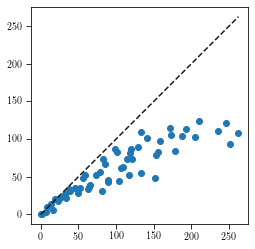

In [1711]:
plt.scatter(pred[1:-1,:,:], measured[1:-1,:,:])
plt.plot([0,mx],[0,mx],'k--')
plt.axis('scaled')

In [1719]:
# Common Ph for all

(-11.936834354400636,
 250.67352144241335,
 -11.936834354400636,
 250.67352144241335)

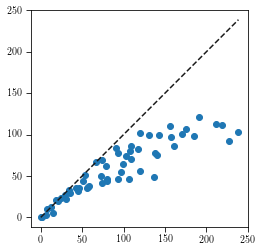

In [1724]:
plt.scatter(pred[1:-1,:,:], measured[1:-1,:,:])
plt.plot([0,mx],[0,mx],'k--')
plt.axis('scaled')

In [1726]:
# Common Tf (5) and Ph for all

(-9.096330471038817,
 191.02293989181516,
 -9.096330471038817,
 191.02293989181516)

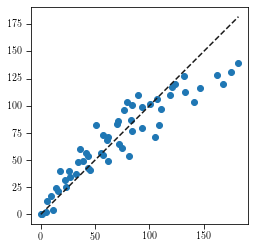

In [1730]:
plt.scatter(pred[1:-1,:,:], measured[1:-1,:,:])
plt.plot([0,mx],[0,mx],'k--')
plt.axis('scaled')

To examine if it's valid (and if so, why) that the flat gain control model still gives freq-dep. suppression, let's consider two stimuli with that have the same prediction but different mixture responses!

In [2012]:
# Original, but 100s?

This doesn't seem to matter? i.e. even if we average over more time, it doesn't matter --> still noisy

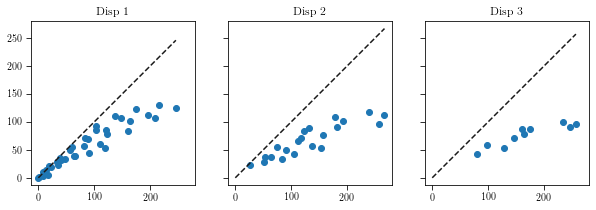

In [2017]:
f, ax = plt.subplots(1, 3, figsize=(10,4), sharex=True, sharey=True);

measured, _, pred, _ = resps

for i in range(3):
    meas = measured[i+1];
    pre = pred[i+1];
    mx = np.maximum(np.nanmax(meas), np.nanmax(pre));
    
    ax[i].scatter(pre, meas)
    ax[i].plot([0, mx], [0, mx], 'k--')
    ax[i].axis('scaled');
    ax[i].set_title('Disp %d' % (i+1))

In [1716]:
# ORIGINAL: i.e. normal TF, normal PH

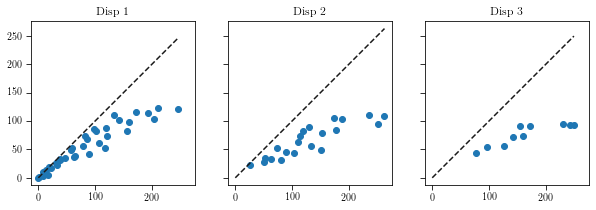

In [1713]:
f, ax = plt.subplots(1, 3, figsize=(10,4), sharex=True, sharey=True);

measured, _, pred, _ = resps

for i in range(3):
    meas = measured[i+1];
    pre = pred[i+1];
    mx = np.maximum(np.nanmax(meas), np.nanmax(pre));
    
    ax[i].scatter(pre, meas)
    ax[i].plot([0, mx], [0, mx], 'k--')
    ax[i].axis('scaled');
    ax[i].set_title('Disp %d' % (i+1))

In [1718]:
# Common Ph for all

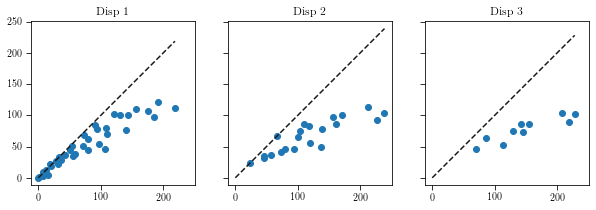

In [1725]:
f, ax = plt.subplots(1, 3, figsize=(10,4), sharex=True, sharey=True);

measured, _, pred, _ = resps

for i in range(3):
    meas = measured[i+1];
    pre = pred[i+1];
    mx = np.maximum(np.nanmax(meas), np.nanmax(pre));
    
    ax[i].scatter(pre, meas)
    ax[i].plot([0, mx], [0, mx], 'k--')
    ax[i].axis('scaled');
    ax[i].set_title('Disp %d' % (i+1))

In [1731]:
# Common Tf (5) and Ph for all

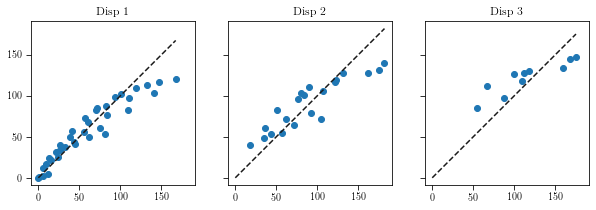

In [1732]:
f, ax = plt.subplots(1, 3, figsize=(10,4), sharex=True, sharey=True);

measured, _, pred, _ = resps

for i in range(3):
    meas = measured[i+1];
    pre = pred[i+1];
    mx = np.maximum(np.nanmax(meas), np.nanmax(pre));
    
    ax[i].scatter(pre, meas)
    ax[i].plot([0, mx], [0, mx], 'k--')
    ax[i].axis('scaled');
    ax[i].set_title('Disp %d' % (i+1))

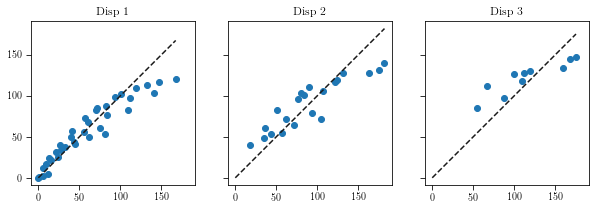

In [1753]:
# SAME AS ABOVE, but different phase value...

f, ax = plt.subplots(1, 3, figsize=(10,4), sharex=True, sharey=True);

measured, _, pred, _ = resps

for i in range(3):
    meas = measured[i+1];
    pre = pred[i+1];
    mx = np.maximum(np.nanmax(meas), np.nanmax(pre));
    
    ax[i].scatter(pre, meas)
    ax[i].plot([0, mx], [0, mx], 'k--')
    ax[i].axis('scaled');
    ax[i].set_title('Disp %d' % (i+1))

In [1757]:
# Common Tf (5) but original Ph

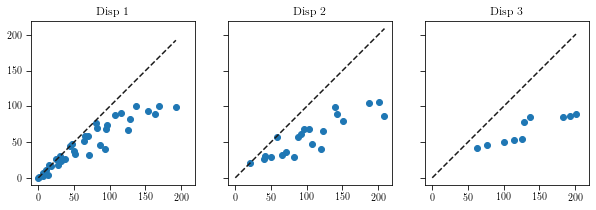

In [1758]:
# SAME AS ABOVE, but different phase value...

f, ax = plt.subplots(1, 3, figsize=(10,4), sharex=True, sharey=True);

measured, _, pred, _ = resps

for i in range(3):
    meas = measured[i+1];
    pre = pred[i+1];
    mx = np.maximum(np.nanmax(meas), np.nanmax(pre));
    
    ax[i].scatter(pre, meas)
    ax[i].plot([0, mx], [0, mx], 'k--')
    ax[i].axis('scaled');
    ax[i].set_title('Disp %d' % (i+1))

In [1687]:
measured[3,:,val_con_by_disp[3][-1]]

array([         nan,          nan,          nan,  97.24065495,
       126.61146336, 144.6160181 , 147.12386265, 133.5189188 ,
                nan,          nan,          nan])

In [1688]:
pred[3,:,val_con_by_disp[3][-1]]

array([         nan,          nan,          nan,  86.96677341,
        99.57173319, 167.59764042, 175.2725337 , 159.62568941,
                nan,          nan,          nan])

So, for example: the highest contrast, highest dispersion, the highest three contrasts have predictions and measurements that don't quite make sense.

Specifically, the prediction with the lowest of those three has the highest measured/mixture response!


In [1733]:
Lexc,Linh,sigmaFilt = psf.get_model_responses(trialInf, good_fit, expInd, cellNum, excType, fitType, f1f0_rat=None, 
                                respMeasure=respMeasure, debug=True,
                                baseline=None, lossType=lossType, lgnFrontEnd=lgnFrontOn, lgnConType=lgnConType)

Lexc = Lexc.detach().numpy();
Linh = Linh.detach().numpy();
sigmaFilt = sigmaFilt.detach().numpy();

The above, however, are in organized in trimmed trials, i.e. excluding blanks. So, let's find the right trial number:

In [1690]:
# vt_0 is a reference (single gratings)
ref_con = val_con_by_disp[0][-1];
disp_lvl = 3;
disp_con = val_con_by_disp[disp_lvl][-1]
vt_0 = hf.get_valid_trials(trialInf, 0, ref_con, 5, expInd, stimVals=stimVals, validByStimVal=val_by_stim_val)[0]
vt_1 = hf.get_valid_trials(trialInf, disp_lvl, disp_con, 5, expInd, stimVals=stimVals, validByStimVal=val_by_stim_val)[0]
vt_2 = hf.get_valid_trials(trialInf, disp_lvl, disp_con, 6, expInd, stimVals=stimVals, validByStimVal=val_by_stim_val)[0]
vt_3 = hf.get_valid_trials(trialInf, disp_lvl, disp_con, 7, expInd, stimVals=stimVals, validByStimVal=val_by_stim_val)[0]

# Get them in the correct trials for what we ran the model on
vt_0_adj = np.where(np.in1d(dw.trInf['num'], vt_0))[0]
vt_1_adj = np.where(np.in1d(dw.trInf['num'], vt_1))[0]
vt_2_adj = np.where(np.in1d(dw.trInf['num'], vt_2))[0]
vt_3_adj = np.where(np.in1d(dw.trInf['num'], vt_3))[0]


First, make sure the stimuli make sense (starting with the reference):

In [1692]:
dw.trInf['con'][vt_0_adj]

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.]])

Ok, phase varies - that's fine

In [1629]:
dw.trInf['ph'][vt_0_adj,0]

tensor([283.8580, 286.7200, 169.0660, 300.0140, 198.9760, 227.4150, 101.1800,
        272.8330, 139.8800, 223.5150])

In [1633]:
dw.trInf['sf'][vt_0_adj,0]

tensor([1.7321, 1.7321, 1.7321, 1.7321, 1.7321, 1.7321, 1.7321, 1.7321, 1.7321,
        1.7321])

In [1634]:
dw.trInf.keys()

dict_keys(['num', 'ori', 'tf', 'ph', 'sf', 'con'])

Ah! The temporal frequencies are different, since this was an experiment which did not keep a fixed relationship between unique component and temporal frequency!

In [1636]:
dw.trInf['tf'][vt_0_adj,0]

tensor([9.2311, 6.6669, 6.3160, 6.3160, 6.6669, 7.5003, 8.0003, 5.4548, 6.6669,
        6.3160])

Nonetheless, look at some example PSTHs:

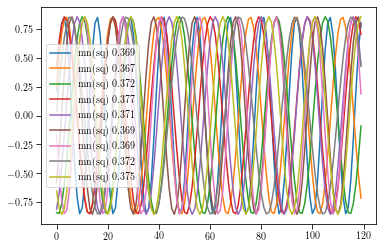

In [2755]:
[plt.plot(Lexc[:,vt], label='mn(sq) %.3f' % np.mean(np.square(Lexc[:,vt]))) for vt in vt_0_adj[0:2]];
plt.legend();

Now, what about the dispersed gratings?

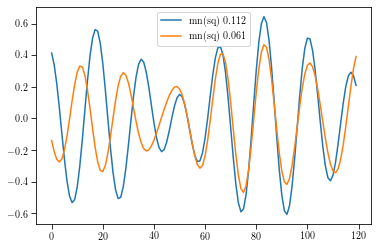

In [2757]:
[plt.plot(Lexc[:,vt], label='mn(sq) %.3f' % np.mean(np.square(Lexc[:,vt]))) for vt in vt_1_adj[0:2]]
plt.legend();

As above, but _different_, common phase!

In [2760]:
[np.unique(Linh[x]) for x in [vt_0_adj, vt_1_adj, vt_2_adj, vt_3_adj]]

[array([1.], dtype=float32),
 array([0.43124738], dtype=float32),
 array([0.43124738], dtype=float32),
 array([0.43124738], dtype=float32)]

### 2. 1 Closer look at the stimulus?

In [1992]:
autoreload.reload(mrpt);

In [1993]:
model = mrpt.sfNormMod(mod_prms, expInd=expInd, excType=excType, normType=fitType, 
                       lossType=lossType, lgnFrontEnd=lgnFrontOn, newMethod=1, 
                       lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm, normToOne=normToOne)

In [1994]:
# P is the matrix that contains the relative location of each filter in space-time (expressed in radians) 
# Omega is the stimulus in space time
# dotprod is the dotproduct of P with Omega

# P is     nTr x nFrames x nComp x {x,y,t}
# ---- but note: P[...,0] and P[...,1] are always zero (x=0,y=0, i.e. centered)
# Omega is mTr x nComp x {x,y,t} (we drift the filters, rather than the stimuli???)

In [1995]:
P, omegas, dotprod, selSi, selSi_stimCo = model.simpleResp_matMul(dw.trInf, sigmoidSigma=sigmoidSigma, debug=True);

realPart = torch.cos(dotprod);
imagPart = torch.sin(dotprod);
# per LCV code: preallocation and then filling in is much more efficient than using stack                                                                                        
realImag = torch.empty((*realPart.shape,2), device=realPart.device);
realImag[...,0] = realPart;
realImag[...,1] = imagPart;

rComplex = torch.einsum('ij,ikjz->ikz', selSi_stimCo, realImag)
rDumb = torch.einsum('ij,ikjz->ijkz', selSi_stimCo, realImag)

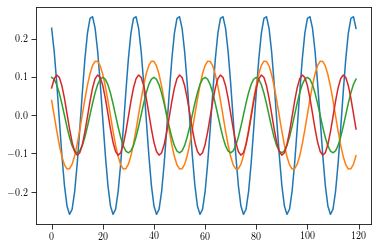

In [1996]:
# Component per response!
plt.plot(rDumb[vt_1_adj[0], 0, :, 0].detach())
plt.plot(rDumb[vt_1_adj[0], 1, :, 0].detach())
plt.plot(rDumb[vt_1_adj[0], 2, :, 0].detach())
plt.plot(rDumb[vt_1_adj[0], 3, :, 0].detach())

For a single gratings, here is the stimlus drifting in time

In [1905]:
import torch
oyvey = torch.cos(dotprod)
print(oyvey.shape)

torch.Size([1660, 120, 7])


In [1892]:
# aaa = torch.mean(torch.pow(torch.sum(oyvey[vt_1_adj[0]], axis=1), 2))
# aa = torch.mean(torch.pow(torch.sum(oyvey[vt_1_adj[1]], axis=1), 2))
# a = torch.mean(torch.pow(torch.sum(oyvey[vt_1_adj[5]], axis=1), 2))


In [1931]:
selSi.shape

torch.Size([1660, 7])

In [1932]:
selSi_stimCo.shape

torch.Size([1660, 7])

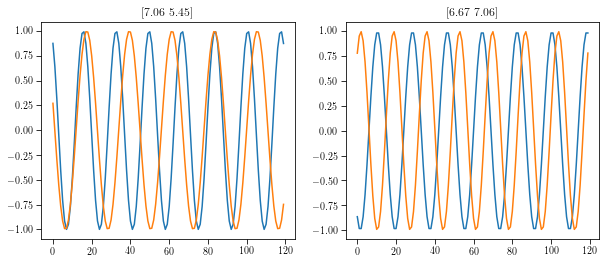

In [1930]:
f, ax = plt.subplots(1,2, figsize=(10,4));
ax[0].plot(oyvey[vt_1_adj[0],:,0])
ax[0].plot(oyvey[vt_1_adj[0],:,1])
ax[0].set_title('%s' % np.array2string(dw.trInf['tf'][vt_1_adj[0],0:2].detach().numpy(), precision=2));


ax[1].plot(oyvey[vt_1_adj[1],:,0])
ax[1].plot(oyvey[vt_1_adj[1],:,1])
ax[1].set_title('%s' % np.array2string(dw.trInf['tf'][vt_1_adj[1],0:2].detach().numpy(), precision=2));


In [1912]:
aaa = torch.mean(torch.pow(torch.sum(oyvey[vt_1_adj[0],:,0:2], axis=1), 2))
aa = torch.mean(torch.pow(torch.sum(oyvey[vt_1_adj[1],:,0:2], axis=1), 2))
a = torch.mean(torch.pow(torch.sum(oyvey[vt_1_adj[5],:,0:2], axis=1), 2))


In [1913]:
print([a,aa,aaa])

[tensor(1.0000), tensor(0.6319), tensor(1.0688)]


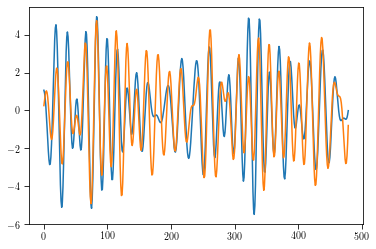

In [1874]:
plt.plot(torch.sum(oyvey[vt_1_adj[0], 0:480], axis=1))
plt.plot(torch.sum(oyvey[vt_1_adj[0], 480:960], axis=1))
# plt.plot(torch.sum(oyvey[vt_1_adj[2], :], axis=1))
# plt.plot(torch.sum(oyvey[vt_1_adj[3], :], axis=1))

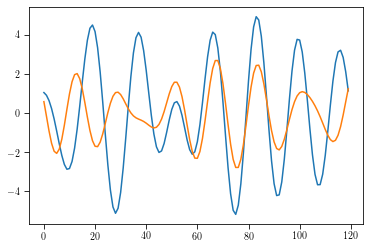

In [1858]:
plt.plot(torch.sum(oyvey[vt_1_adj[0], :], axis=1))
plt.plot(torch.sum(oyvey[vt_1_adj[1], :], axis=1))
# plt.plot(torch.sum(oyvey[vt_1_adj[2], :], axis=1))
# plt.plot(torch.sum(oyvey[vt_1_adj[3], :], axis=1))

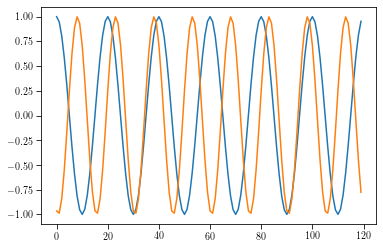

In [1845]:
np.sum
plt.plot(oyvey[vt_1_adj[0], :, 0])
plt.plot(oyvey[vt_1_adj[0], :, 5])

### 2.2 Now, try for an experiment which we know was designed properly!
Recall that the altExp/ stimuli had TFs drawn from a Gaussian - thus, each draw of a stimulus did not necessarily have the same TFs for each component.

However, all subsequent version of the experiment (i.e. V1/, V1_BB/) made each SF linked with a TF, i.e. any presentation of SF_i had TF_i.

In [2773]:
autoreload.reload(mrpt);
autoreload.reload(hf);
autoreload.reload(psf);

In [2769]:
fitList_nm = 'fitList_pyt_221013_noRE_noSched_flat_sqrt.npy'

In [ ]:
trial

In [2770]:
cellNum = 40
expDir = 'V1/'
respMeasure = 0; # dc [0] or f1 [1]

excType = 2; # 1 is deriv. order, 2 is flex. gauss
lossType = 1
fitType = 1 # flat [1], tuned [2] or gain tuned[5]
lgnFrontOn = 0
lgnConType = 1
_LGNforNorm = 0
normToOne = True;
recenter_norm = 2;
_sigmoidSigma = 5;

### Load data (to use for vExp calc.)
data_loc = base_dir + '%sstructures/' % expDir
expName = hf.get_datalist(expDir, force_full=True);
dataList = hf.np_smart_load(str(data_loc + expName))
expInd   = hf.exp_name_to_ind(dataList['expType'][cellNum-1]);

if respMeasure == 1:
    rvcName = 'rvcFitsHPC_220928'
    rvcFits = hf.get_rvc_fits(data_loc, expInd, cellNum, rvcName=rvcName, rvcMod=1, direc=1, vecF1=0);
    get_adj_spikes = hf.get_adjusted_spikerate(trialInf, cellNum, expInd, data_loc, rvcName=rvcFits, rvcMod=-1, 
                                               baseline_sub=False, return_measure=False, vecF1=0, force_f1=True, returnByComp=True)

expData = hf.np_smart_load(data_loc + '%s_sfm.npy' % dataList['unitName'][cellNum-1])
trialInf = expData['sfm']['exp']['trial']
respOverwrite = None if respMeasure==0 else get_adj_spikes;
dw = mrpt.dataWrapper(trialInf, respMeasure=respMeasure, expInd=expInd, 
                      respOverwrite=respOverwrite)#, shufflePh=True, shuffleTf=True)

In [2771]:
good_fit = hf.np_smart_load('%sstructures/%s' % (expDir, fitList_nm))
respStr = 'dc' if respMeasure == 0 else 'f1'
mod_prms = good_fit[cellNum-1][respStr]['params']

In [2890]:
model = mrpt.sfNormMod(mod_prms, expInd=expInd, excType=excType, normType=fitType, 
                       lossType=lossType, lgnFrontEnd=lgnFrontOn, newMethod=1, 
                       lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm, normToOne=normToOne)

modResp = model.forward(dw.trInf, respMeasure=respMeasure, sigmoidSigma=_sigmoidSigma, recenter_norm=recenter_norm).detach().numpy();
oy = gather_into_full_resp(dw, trialInf, expInd, modResp);



resps = psf.get_model_responses(trialInf, mod_prms, expInd, cellNum, excType, fitType, f1f0_rat=None, 
                                respMeasure=respMeasure,
                                baseline=None, lossType=lossType, lgnFrontEnd=lgnFrontOn, lgnConType=lgnConType)
# Used for superposition analysis!
measured, _, pred, _ = resps

We'll use this to compare the response of a given component (from rComponent) to the overall response (rComplex).

Note that the below (rComplex, rComponent) are _just_ the linear filter, i.e. no normalization, no thresholding.



In [2880]:
realImag, selSi, selSi_stimCo = model.simpleResp_matMul(dw.trInf, sigmoidSigma=sigmoidSigma, debug=True);
# P, omegas, dotprod, selSi, selSi_stimCo = model.simpleResp_matMul(dw.trInf, sigmoidSigma=sigmoidSigma, debug=True);

rComplex = torch.einsum('ij,ikjz->ikz', selSi_stimCo, realImag).detach().numpy()
rComponent = torch.einsum('ij,ikjz->ijkz', selSi_stimCo, realImag).detach().numpy()

In [2881]:
# First, note that rComplex is simply the sum of rComponent (up to 1e-6):
np.unique(np.isclose(rComplex, np.sum(rComponent,axis=1), atol=1e-6))

array([ True])

Let's look at an arbitrary 3-mixture:

In [2882]:
to_match = 3; # i.e. how many components in mixture

nGrats = np.array([np.sum(dw.trInf['con'][x].detach().numpy()>0) for x in range(len(dw.trInf['con']))])
trs = np.where(nGrats==to_match)[0];

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  import sys


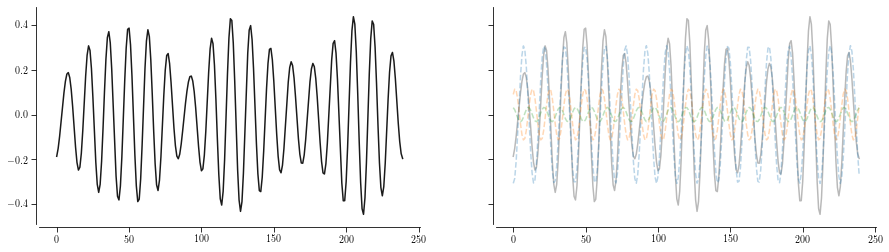

In [2883]:
f, ax = plt.subplots(1,2,figsize=(15,4), sharex=True, sharey=True)
# first, the mixture response
curr_tr = trs[np.random.randint(low=0, high=len(trs), size=1)];
ax[0].plot(rComplex[curr_tr,:,0].flatten(), 'k-');
# then, it's individual components + sum
[ax[1].plot(rComponent[curr_tr,comp,:,0].flatten(), alpha=0.3, linestyle='--') for comp in range(to_match)];
ax[1].plot(np.sum(rComponent[curr_tr,:,:,0], axis=1).flatten(), 'k-', alpha=0.3, zOrder=-10);

sns.despine(offset=3)

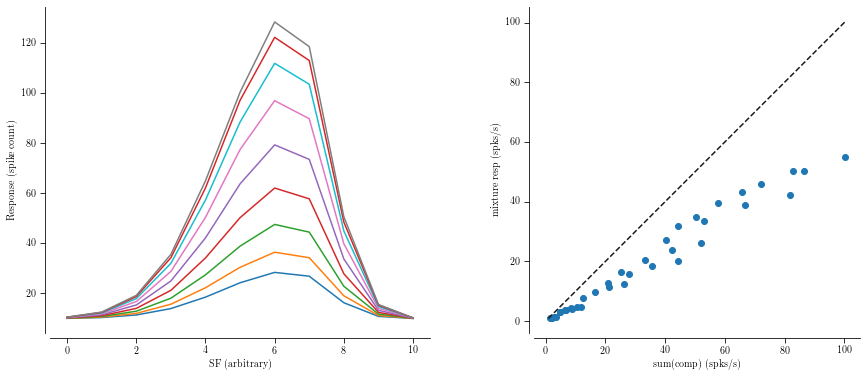

In [2899]:
# What does the tuning look like?
f, ax = plt.subplots(1,2,figsize=(15,6))

# single grating SF
[ax[0].plot(hf.nan_rm(x)) for x in np.transpose(oy[0])];
ax[0].set_xlabel('SF (arbitrary)');
ax[0].set_ylabel('Response (spike count)');

# mixture summation --> just 3-mixes
which_ind = np.where(np.arange(1,7+1,2) == 3)[0]

ax[1].scatter(pred[which_ind].flatten(), measured[which_ind].flatten())
mn = np.minimum(np.nanmin(pred[which_ind]), np.nanmin(measured[which_ind]))
mx = np.maximum(np.nanmax(pred[which_ind]), np.nanmax(measured[which_ind]))
ax[1].plot([mn,mx],[mn,mx], 'k--')
ax[1].axis('scaled')
ax[1].set_xlabel('sum(comp) (spks/s)');
ax[1].set_ylabel('mixture resp (spks/s)');

sns.despine(offset=5)

Note, for example, the two mixtures with the 3rd and 4th highest predicted response --> they are quite similar, and yet have a more marked difference in mixture response. Let's look closely at these trials:

In [2923]:
hmm = np.where(np.logical_and(pred[which_ind]>78, pred[which_ind]<85))
print(hmm)

tr1 = (which_ind[0], hmm[1][0], hmm[2][0])
tr2 = (which_ind[0], hmm[1][1], hmm[2][1])

(array([0, 0]), array([5, 6]), array([16, 12]))


In [2931]:
print('[Pred] %.1f --> %.1f [mixture]' % (pred[tr1], measured[tr1]))
print('[Pred] %.1f --> %.1f [mixture]' % (pred[tr2], measured[tr2]))

[Pred] 81.8 --> 42.3 [mixture]
[Pred] 82.7 --> 50.3 [mixture]


In [2977]:
curr_trs_tr1, allDisps, allCons, allSfs = hf.get_valid_trials(trialInf, tr1[0], tr1[2], tr1[1], expInd)
curr_trs_tr1 = curr_trs_tr1[0]
curr_trs_tr2 = hf.get_valid_trials(trialInf, tr2[0], tr2[2], tr2[1], expInd)[0][0]

comp = 0; # get the valid_trials for the Nth component

con_match = trialInf['con'][comp, curr_trs_tr1[0]]
sf_match = trialInf['sf'][comp, curr_trs_tr1[0]]

con_ind = np.where(np.in1d(np.round(allCons, 3), np.round(con_match, 3)))[0][0];
sf_ind = np.where(np.in1d(allSfs, sf_match))[0][0];

isol_trials_curr = hf.get_valid_trials(trialInf, disp=0, con=con_ind, sf=sf_ind, expInd=expInd)[0][0]

## get both in model terms...(just one ex. trial for now)
ex_mix_tr1 = np.where(dw.trInf['num']==curr_trs_tr1[0])[0][0]
ex_isol_tr1 = np.where(dw.trInf['num']==isol_trials_curr[0])[0]

In [3067]:
oy = hf.spike_fft([rComponent[ex_mix_tr1, comp, :,0].flatten()], 
                            tfs=[trialInf['tf'][comp, curr_trs_tr1[0]]], 
                            stimDur=hf.get_exp_params(expInd).stimDur)[0][0]

vey = hf.spike_fft([rComplex[ex_mix_tr1,:,0].flatten()], 
                            tfs=[curr_tf], 
                            stimDur=hf.get_exp_params(expInd).stimDur)[0][0]

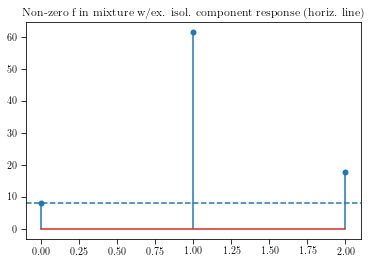

In [3074]:
plt.stem(vey[vey>0.1]); # non zeros..
plt.axhline(oy[oy>0.1], linestyle='--')
plt.title('Non-zero f in mixture w/ex. isol. component response (horiz. line)');

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


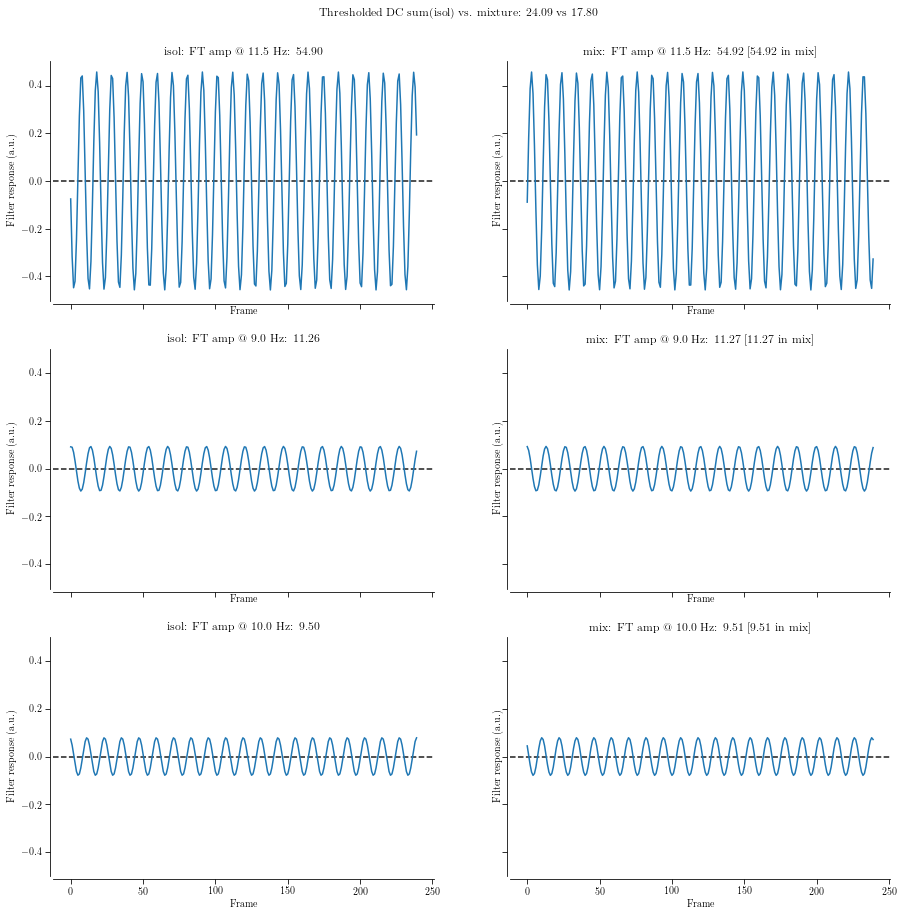

In [3168]:
f, ax = plt.subplots(to_match, 2, figsize=(15,to_match*5), sharex=True, sharey=True);

which_ref_trials = curr_trs_tr2[2];

sum_isol_dc = 0;

for comp in range(to_match):

    con_match = trialInf['con'][comp, which_ref_trials]
    sf_match = trialInf['sf'][comp, which_ref_trials]

    con_ind = np.where(np.in1d(np.round(allCons, 3), np.round(con_match, 3)))[0][0];
    sf_ind = np.where(np.in1d(np.round(allSfs, 3), np.round(sf_match, 3)))[0][0];

    isol_trials_curr = hf.get_valid_trials(trialInf, disp=0, con=con_ind, sf=sf_ind, expInd=expInd)[0][0]

    ## get both in model terms...(just one ex. trial for now)
    ex_mix_tr1 = np.where(dw.trInf['num']==which_ref_trials)[0][0]
    ex_isol_tr1 = np.where(dw.trInf['num']==isol_trials_curr[0])[0]
    
    # first, isol. resp:
    ax[comp, 0].plot(rComplex[ex_isol_tr1,:,0].flatten());
    curr_tf = dw.trInf['tf'][ex_isol_tr1, 0] # isol --> so get 0 component tf
    curr_amp = hf.spike_fft([rComplex[ex_isol_tr1,:,0].flatten()], 
                            tfs=[curr_tf], 
                            stimDur=hf.get_exp_params(expInd).stimDur)[1];
    ax[comp, 0].set_title('isol: FT amp @ %.1f Hz: %.2f' % (curr_tf, curr_amp))

    # then, comp. in mixture:
    ax[comp, 1].plot(rComponent[ex_mix_tr1, comp, :,0].flatten());
    curr_tf = dw.trInf['tf'][ex_mix_tr1, comp]
    curr_amp_isol = hf.spike_fft([rComponent[ex_mix_tr1, comp, :,0].flatten()], 
                            tfs=[trialInf['tf'][comp, which_ref_trials]], 
                            stimDur=hf.get_exp_params(expInd).stimDur)[1];
    curr_amp_mix = hf.spike_fft([rComplex[ex_mix_tr1,:,0].flatten()], 
                            tfs=[curr_tf], 
                            stimDur=hf.get_exp_params(expInd).stimDur)[1];
    ax[comp, 1].set_title('mix: FT amp @ %.1f Hz: %.2f [%.2f in mix]' % (curr_tf, curr_amp_isol, curr_amp_mix))

    # now, threshold - ask what is DC?
    curr_dc = hf.spike_fft([np.maximum(0, rComplex[ex_isol_tr1,:,0].flatten())], 
                            tfs=[curr_tf], 
                            stimDur=hf.get_exp_params(expInd).stimDur)[0];
    
    sum_isol_dc += curr_dc[0][0]
    
    for i in range(2):
        ax[comp, i].axhline(0, color='k', linestyle='--', zOrder=-10)
        ax[comp, i].set_xlabel('Frame')
        ax[comp, i].set_ylabel('Filter response (a.u.)')

mix_dc = hf.spike_fft([np.maximum(0, rComplex[ex_mix_tr1,:,0].flatten())], 
                            tfs=[curr_tf], 
                            stimDur=hf.get_exp_params(expInd).stimDur)[0][0][0];
        
f.suptitle('Thresholded DC sum(isol) vs. mixture: %.2f vs %.2f' % (sum_isol_dc, mix_dc), y=0.93)
sns.despine(offset=3);

Clearly, no issue with the F1. What about the DC values? The consistently lower DC values reflects, I believe, the interference that comes from superimposed drifting gratings. This results from the thresholding. But is that the same as taking into account cross-terms?

##### This isolates the problem to somewhere _after_ rComplex

In [3108]:
Lexc,Linh,sigmaFilt = psf.get_model_responses(trialInf, mod_prms, expInd, cellNum, excType, fitType, f1f0_rat=None, 
                                respMeasure=respMeasure, debug=True,
                                baseline=None, lossType=lossType, lgnFrontEnd=lgnFrontOn, lgnConType=lgnConType)

Lexc = Lexc.detach().numpy();
Linh = Linh.detach().numpy();
sigmaFilt = sigmaFilt.detach().numpy();

[ True]


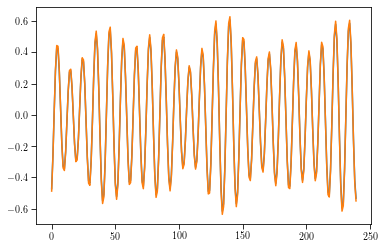

In [3113]:
rcmp = rComplex[ex_mix_tr1,:,0].flatten()
plt.plot(rcmp)
plt.plot(rcmp/np.max(rComplex[:,:,0]));

print(np.unique(np.isclose(rcmp/np.max(rComplex[:,:,0]), Lexc[:,ex_mix_tr1])))

_Note: Lexc and our within-notebook computed rComplex are the same --> the later just needs to be normalized by the maximum value to mimic the only additional processing step in the actual model code._

In [3121]:
numerator    = Lexc
denominator  = np.power(sigmaFilt + np.power(Linh, 2), 0.5); # nTrials 
rawResp      = torch.div(mrpt._cast_as_tensor(numerator), mrpt._cast_as_tensor(denominator).unsqueeze(0)).detach().numpy();

In [3140]:
dw.trInf['con'][trz_1]

tensor([[0.6876, 0.1538, 0.1538, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.6876, 0.1538, 0.1538, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.6876, 0.1538, 0.1538, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.6876, 0.1538, 0.1538, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.6876, 0.1538, 0.1538, 0.0000, 0.0000, 0.0000, 0.0000]])

In [3141]:
dw.trInf['con'][trz_2]

tensor([[0.4731, 0.1058, 0.1058, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4731, 0.1058, 0.1058, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4731, 0.1058, 0.1058, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4731, 0.1058, 0.1058, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4731, 0.1058, 0.1058, 0.0000, 0.0000, 0.0000, 0.0000]])

In [3135]:
# check: Denominator the same within a given condition? Yes...
trz_1 = np.where(np.in1d(dw.trInf['num'], curr_trs_tr1))[0]
denom_1 = np.unique(denominator[trz_1])

trz_2 = np.where(np.in1d(dw.trInf['num'], curr_trs_tr2))[0]
denom_2 = np.unique(denominator[trz_2])

print('%.2f vs. %.2f' % (denom_1, denom_2))

0.80 vs. 0.60


You fool! They just have different denominators, because they have a different total contrast!

Is there a way to use the model to save the analysis??? Or is it OK, regardless?
- Can it be saved by passing through (forward or inverse?) the RVCs (which would depend on SF)

### 2.3 Quickly look at single gratings?

In [3433]:
autoreload.reload(mrpt);

In [3434]:
fitList_nm = 'fitListHPC_pyt_221014_noRE_noSched_flat_sqrt.npy'

In [3435]:
cellNum = 4
expDir = 'altExp/'
respMeasure = 0; # dc [0] or f1 [1]

excType = 2; # 1 is deriv. order, 2 is flex. gauss
lossType = 1
fitType = 1 # flat [1], tuned [2] or gain tuned[5]
lgnFrontOn = 0
lgnConType = 1
_LGNforNorm = 0
normToOne = True;
recenter_norm = 2;
_sigmoidSigma = 5;

### Load data (to use for vExp calc.)
data_loc = base_dir + '%sstructures/' % expDir
expName = hf.get_datalist(expDir, force_full=True);
dataList = hf.np_smart_load(str(data_loc + expName))
expInd   = hf.exp_name_to_ind(dataList['expType'][cellNum-1]);

expData = hf.np_smart_load(data_loc + '%s_sfm.npy' % dataList['unitName'][cellNum-1])
trialInf = expData['sfm']['exp']['trial']

good_fit = hf.np_smart_load('%sstructures/%s' % (expDir, fitList_nm))
respStr = 'dc' if respMeasure == 0 else 'f1'
mod_prms = good_fit[cellNum-1][respStr]['params']

In [3517]:
dw = mrpt.dataWrapper(trialInf, respMeasure=respMeasure, expInd=expInd, 
                      respOverwrite=respOverwrite)#, shuffleTf=True, shufflePh=True);

In [3518]:
model = mrpt.sfNormMod(mod_prms, expInd=expInd, excType=excType, normType=fitType, 
                       lossType=lossType, lgnFrontEnd=lgnFrontOn, newMethod=1, 
                       lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm, normToOne=normToOne)

modResp = model.forward(dw.trInf, respMeasure=respMeasure, sigmoidSigma=_sigmoidSigma, recenter_norm=recenter_norm).detach().numpy();
oy = gather_into_full_resp(dw, trialInf, expInd, modResp);


resps = psf.get_model_responses(trialInf, mod_prms, expInd, cellNum, excType, fitType, f1f0_rat=None, 
                                respMeasure=respMeasure,
                                baseline=None, lossType=lossType, lgnFrontEnd=lgnFrontOn, lgnConType=lgnConType)
# Used for superposition analysis!
measured, _, pred, _ = resps

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5146: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);


In [3519]:
realImag, selSi, selSi_stimCo = model.simpleResp_matMul(dw.trInf, sigmoidSigma=sigmoidSigma, debug=True);
# P, omegas, dotprod, selSi, selSi_stimCo = model.simpleResp_matMul(dw.trInf, sigmoidSigma=sigmoidSigma, debug=True);

rComplex = torch.einsum('ij,ikjz->ikz', selSi_stimCo, realImag).detach().numpy()
rComponent = torch.einsum('ij,ikjz->ijkz', selSi_stimCo, realImag).detach().numpy()

In [3337]:
# sings = np.where(dw.trInf['con'][:,1]==0)[0] # i.e. single grating only
sings = np.where(dw.trInf['con'][:,0]==1)[0] # full contrast, single grats

Here, we've forced tf=2Hz:

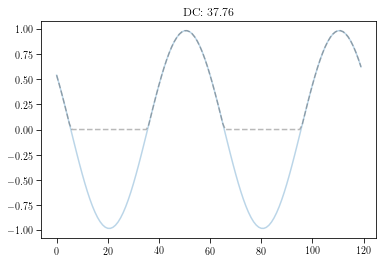

In [3363]:
curr_tr = sings[1]
# curr_tr = sings[np.random.randint(0,len(sings))]

curr_sig = rComplex[curr_tr, :, 0];
curr_dc = hf.spike_fft([np.maximum(0, curr_sig)], stimDur=hf.get_exp_params(expInd).stimDur, )[0][0][0]
plt.plot(curr_sig, alpha=0.3);
plt.plot(np.maximum(0,curr_sig), 'k--', alpha=0.3)
plt.title('DC: %.2f' % curr_dc);

Here, tf=5Hz:

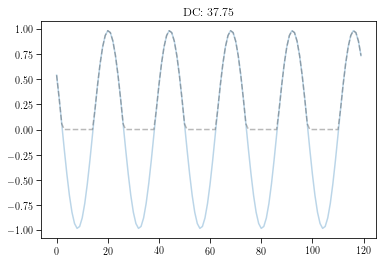

In [3358]:
curr_tr = sings[1]
# curr_tr = sings[np.random.randint(0,len(sings))]

curr_sig = rComplex[curr_tr, :, 0];
curr_dc = hf.spike_fft([np.maximum(0, curr_sig)], stimDur=hf.get_exp_params(expInd).stimDur, )[0][0][0]
plt.plot(curr_sig, alpha=0.3);
plt.plot(np.maximum(0,curr_sig), 'k--', alpha=0.3)
plt.title('DC: %.2f' % curr_dc);

Here, tf=5.5Hz :

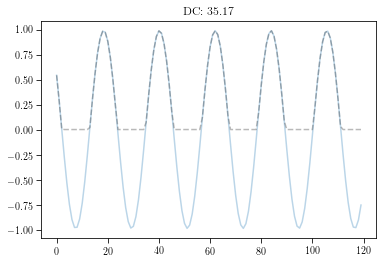

In [3353]:
curr_tr = sings[1]
# curr_tr = sings[np.random.randint(0,len(sings))]

curr_sig = rComplex[curr_tr, :, 0];
curr_dc = hf.spike_fft([np.maximum(0, curr_sig)], stimDur=hf.get_exp_params(expInd).stimDur, )[0][0][0]
plt.plot(curr_sig, alpha=0.3);
plt.plot(np.maximum(0,curr_sig), 'k--', alpha=0.3)
plt.title('DC: %.2f' % curr_dc);

Here, original TF:

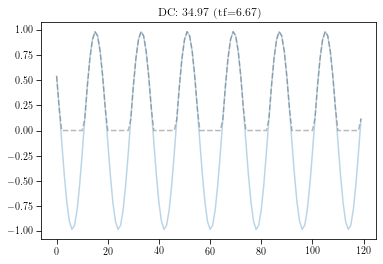

In [3343]:
curr_tr = sings[1]
# curr_tr = sings[np.random.randint(0,len(sings))]

curr_sig = rComplex[curr_tr, :, 0];
curr_dc = hf.spike_fft([np.maximum(0, curr_sig)], stimDur=hf.get_exp_params(expInd).stimDur, )[0][0][0]
plt.plot(curr_sig, alpha=0.3);
plt.plot(np.maximum(0,curr_sig), 'k--', alpha=0.3)
plt.title('DC: %.2f (tf=%.2f)' % (curr_dc, dw.trInf['tf'][curr_tr,0]));

Here, original TF - but normalizing rComplex based on abs(max), not just max:

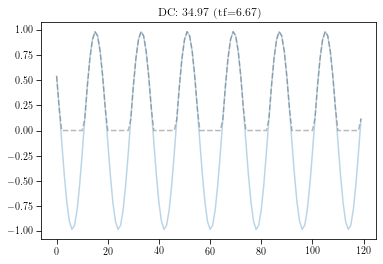

In [3431]:
curr_tr = sings[1]
# curr_tr = sings[np.random.randint(0,len(sings))]

curr_sig = rComplex[curr_tr, :, 0];
curr_dc = hf.spike_fft([np.maximum(0, curr_sig)], stimDur=hf.get_exp_params(expInd).stimDur, )[0][0][0]
plt.plot(curr_sig, alpha=0.3);
plt.plot(np.maximum(0,curr_sig), 'k--', alpha=0.3)
plt.title('DC: %.2f (tf=%.2f)' % (curr_dc, dw.trInf['tf'][curr_tr,0]));

Again, original TF, but now randomized Ph:

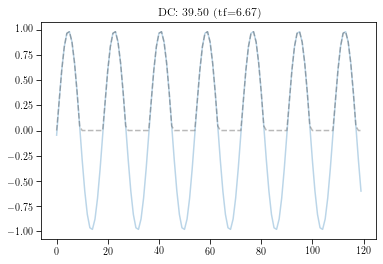

In [3347]:
curr_tr = sings[1]
# curr_tr = sings[np.random.randint(0,len(sings))]

curr_sig = rComplex[curr_tr, :, 0];
curr_dc = hf.spike_fft([np.maximum(0, curr_sig)], stimDur=hf.get_exp_params(expInd).stimDur, )[0][0][0]
plt.plot(curr_sig, alpha=0.3);
plt.plot(np.maximum(0,curr_sig), 'k--', alpha=0.3)
plt.title('DC: %.2f (tf=%.2f)' % (curr_dc, dw.trInf['tf'][curr_tr,0]));

### 2.4 Why is it that integer TFs (typically?) yield smaller DC values than non-integer TFs? Perhaps it's just a by-product of thresholding a signal with non-integer cycles? 

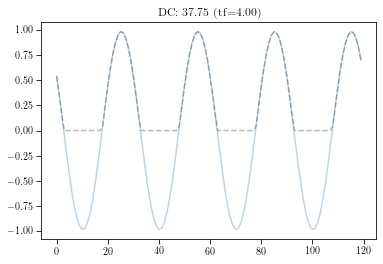

In [3443]:
curr_tr = sings[1]
# curr_tr = sings[np.random.randint(0,len(sings))]

curr_sig = rComplex[curr_tr, :, 0];
curr_dc = hf.spike_fft([np.maximum(0, curr_sig)], stimDur=hf.get_exp_params(expInd).stimDur, )[0][0][0]
plt.plot(curr_sig, alpha=0.3);
plt.plot(np.maximum(0,curr_sig), 'k--', alpha=0.3)
plt.title('DC: %.2f (tf=%.2f)' % (curr_dc, dw.trInf['tf'][curr_tr,0]));

In [3452]:
ref_dc = 37.75;

Now, just take half the signal (will still be int. number of cycles):

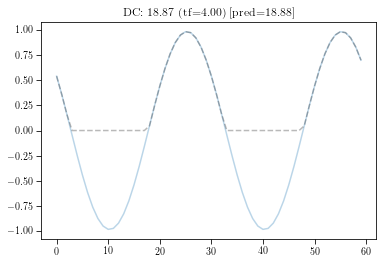

In [3453]:
frac = 0.5

curr_tr = sings[1]
# curr_tr = sings[np.random.randint(0,len(sings))]

curr_sig = rComplex[curr_tr, 0:int(frac*rComplex.shape[1]), 0];
curr_dc = hf.spike_fft([np.maximum(0, curr_sig)], stimDur=hf.get_exp_params(expInd).stimDur, )[0][0][0]
plt.plot(curr_sig, alpha=0.3);
plt.plot(np.maximum(0,curr_sig), 'k--', alpha=0.3)
plt.title('DC: %.2f (tf=%.2f) [pred=%.2f]' % (curr_dc, dw.trInf['tf'][curr_tr,0], frac*ref_dc));

Ok, that gives half of the DC response from above - makes sense. But if we do, for example, 60% (non-int # of cycles)

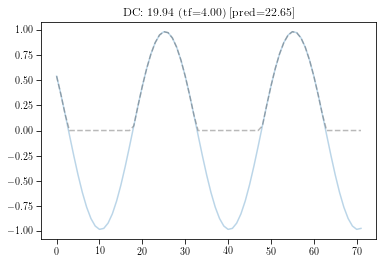

In [3454]:
frac = 0.6

curr_tr = sings[1]
# curr_tr = sings[np.random.randint(0,len(sings))]

curr_sig = rComplex[curr_tr, 0:int(frac*rComplex.shape[1]), 0];
curr_dc = hf.spike_fft([np.maximum(0, curr_sig)], stimDur=hf.get_exp_params(expInd).stimDur, )[0][0][0]
plt.plot(curr_sig, alpha=0.3);
plt.plot(np.maximum(0,curr_sig), 'k--', alpha=0.3)
plt.title('DC: %.2f (tf=%.2f) [pred=%.2f]' % (curr_dc, dw.trInf['tf'][curr_tr,0], frac*ref_dc));

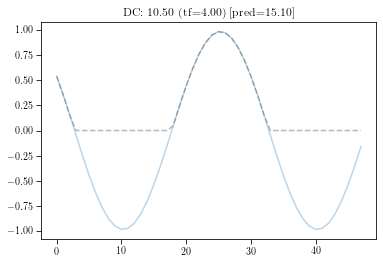

In [3455]:
frac = 0.4

curr_tr = sings[1]
# curr_tr = sings[np.random.randint(0,len(sings))]

curr_sig = rComplex[curr_tr, 0:int(frac*rComplex.shape[1]), 0];
curr_dc = hf.spike_fft([np.maximum(0, curr_sig)], stimDur=hf.get_exp_params(expInd).stimDur, )[0][0][0]
plt.plot(curr_sig, alpha=0.3);
plt.plot(np.maximum(0,curr_sig), 'k--', alpha=0.3)
plt.title('DC: %.2f (tf=%.2f) [pred=%.2f]' % (curr_dc, dw.trInf['tf'][curr_tr,0], frac*ref_dc));

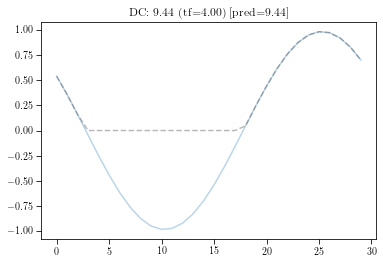

In [3456]:
frac = 0.25

curr_tr = sings[1]
# curr_tr = sings[np.random.randint(0,len(sings))]

curr_sig = rComplex[curr_tr, 0:int(fr ac*rComplex.shape[1]), 0];
curr_dc = hf.spike_fft([np.maximum(0, curr_sig)], stimDur=hf.get_exp_params(expInd).stimDur, )[0][0][0]
plt.plot(curr_sig, alpha=0.3);
plt.plot(np.maximum(0,curr_sig), 'k--', alpha=0.3)
plt.title('DC: %.2f (tf=%.2f) [pred=%.2f]' % (curr_dc, dw.trInf['tf'][curr_tr,0], frac*ref_dc));

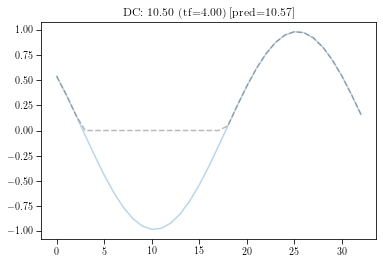

In [3467]:
frac = 0.28

curr_tr = sings[1]
# curr_tr = sings[np.random.randint(0,len(sings))]

curr_sig = rComplex[curr_tr, 0:int(frac*rComplex.shape[1]), 0];
curr_dc = hf.spike_fft([np.maximum(0, curr_sig)], stimDur=hf.get_exp_params(expInd).stimDur, )[0][0][0]
plt.plot(curr_sig, alpha=0.3);
plt.plot(np.maximum(0,curr_sig), 'k--', alpha=0.3)
plt.title('DC: %.2f (tf=%.2f) [pred=%.2f]' % (curr_dc, dw.trInf['tf'][curr_tr,0], frac*ref_dc));

Now, more systematically:

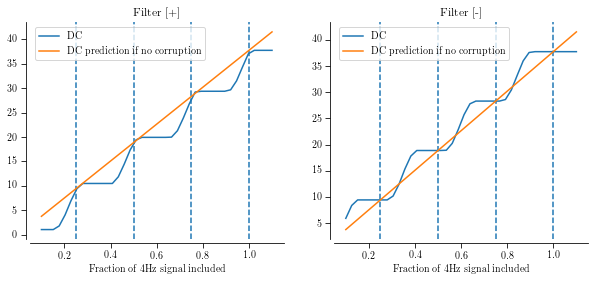

In [3508]:
tf = 4; # in mrpt.process_data, set Tf to be 4Hz
fracs = np.linspace(0.1,1.1,tf*10);

f, ax = plt.subplots(1,2, figsize=(10,4));

for i in range(2):
    curr_dcs = [hf.spike_fft([np.maximum(0, np.power(-1,i)*rComplex[curr_tr, 0:int(frac*rComplex.shape[1]), 0])], 
                             stimDur=hf.get_exp_params(expInd).stimDur,)[0][0][0] for frac in fracs]
    ax[i].plot(fracs, curr_dcs, label='DC');
    [ax[i].axvline(x/4, linestyle='--') for x in range(1,1+tf)];
    ax[i].plot(fracs, fracs*ref_dc, label='DC prediction if no corruption');
    ax[i].set_xlabel('Fraction of 4Hz signal included')

    ax[i].legend();
    ax[i].set_title('Filter [%s]' % ('+' if i==0 else '-'))

sns.despine(offset=4)



And a few more times, with shuffled Ph:

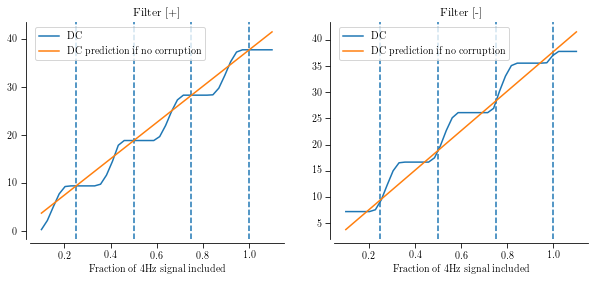

In [3512]:
tf = 4; # in mrpt.process_data, set Tf to be 4Hz
fracs = np.linspace(0.1,1.1,tf*10);

f, ax = plt.subplots(1,2, figsize=(10,4));

for i in range(2):
    curr_dcs = [hf.spike_fft([np.maximum(0, np.power(-1,i)*rComplex[curr_tr, 0:int(frac*rComplex.shape[1]), 0])], 
                             stimDur=hf.get_exp_params(expInd).stimDur,)[0][0][0] for frac in fracs]
    ax[i].plot(fracs, curr_dcs, label='DC');
    [ax[i].axvline(x/4, linestyle='--') for x in range(1,1+tf)];
    ax[i].plot(fracs, fracs*ref_dc, label='DC prediction if no corruption');
    ax[i].set_xlabel('Fraction of 4Hz signal included')

    ax[i].legend();
    ax[i].set_title('Filter [%s]' % ('+' if i==0 else '-'))

sns.despine(offset=4)



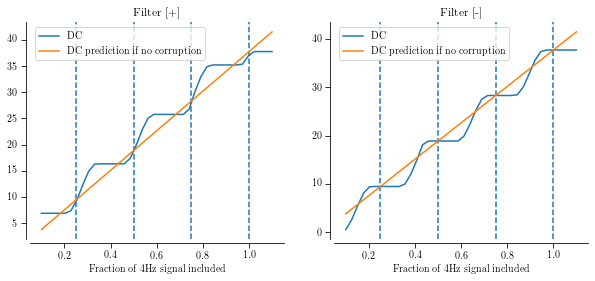

In [3520]:
tf = 4; # in mrpt.process_data, set Tf to be 4Hz
fracs = np.linspace(0.1,1.1,tf*10);

f, ax = plt.subplots(1,2, figsize=(10,4));

for i in range(2):
    curr_dcs = [hf.spike_fft([np.maximum(0, np.power(-1,i)*rComplex[curr_tr, 0:int(frac*rComplex.shape[1]), 0])], 
                             stimDur=hf.get_exp_params(expInd).stimDur,)[0][0][0] for frac in fracs]
    ax[i].plot(fracs, curr_dcs, label='DC');
    [ax[i].axvline(x/4, linestyle='--') for x in range(1,1+tf)];
    ax[i].plot(fracs, fracs*ref_dc, label='DC prediction if no corruption');
    ax[i].set_xlabel('Fraction of 4Hz signal included')

    ax[i].legend();
    ax[i].set_title('Filter [%s]' % ('+' if i==0 else '-'))

sns.despine(offset=4)



_Summary_: **The thresholding is why non-integer TFs can give different results than integer TFs.** Note that integer TFs here means Tfs which give an integer number of cycles (which also includes 2.5Hz for a 2s signal, for example). Furthermore, the DC depends on which filter we choose (the +/- represent two of the four possible quadrature filters) and the phase of the stimulus (as evident by the three different runs with different phases).

### 2.5 Just make sure that we cannot get F1 from quadrature
We'll force TF to an integer value (e.g. 5 Hz)

In [3571]:
autoreload.reload(mrpt);

In [3572]:
dw = mrpt.dataWrapper(trialInf, respMeasure=respMeasure, expInd=expInd, 
                      respOverwrite=respOverwrite, shuffleTf=True, shufflePh=True);

In [3573]:
model = mrpt.sfNormMod(mod_prms, expInd=expInd, excType=excType, normType=fitType, 
                       lossType=lossType, lgnFrontEnd=lgnFrontOn, newMethod=1, 
                       lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm, normToOne=normToOne)

modResp = model.forward(dw.trInf, respMeasure=respMeasure, sigmoidSigma=_sigmoidSigma, recenter_norm=recenter_norm).detach().numpy();
oy = gather_into_full_resp(dw, trialInf, expInd, modResp);


resps = psf.get_model_responses(trialInf, mod_prms, expInd, cellNum, excType, fitType, f1f0_rat=None, 
                                respMeasure=respMeasure,
                                baseline=None, lossType=lossType, lgnFrontEnd=lgnFrontOn, lgnConType=lgnConType)
# Used for superposition analysis!
measured, _, pred, _ = resps

/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:5146: RuntimeWarning: Mean of empty slice
  rateSfMix = numpy.nanmean(allSfMix, -1);


In [3574]:
resp__ = model.simpleResp_matMul(dw.trInf, sigmoidSigma=sigmoidSigma, debug=False, quadrature=False).detach().numpy();

# and again, but quadrature:
resp__quadr = model.simpleResp_matMul(dw.trInf, sigmoidSigma=sigmoidSigma, debug=False, quadrature=True).detach().numpy();

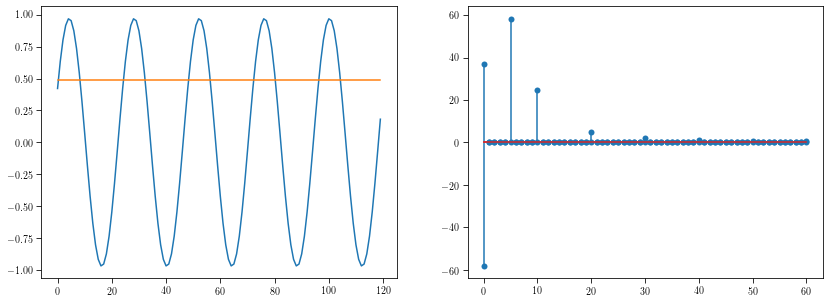

In [3590]:
f, ax = plt.subplots(1,2, figsize=(14,5));

sings = np.where(dw.trInf['con'][:,0]==1)[0] # full contrast, single grats
ex_tr = sings[np.random.randint(len(sings))]
curr_tf = dw.trInf['tf'][ex_tr, 0].detach().numpy();


# Trajectory
ax[0].plot(resp__[:,ex_tr]);
ax[0].plot(resp__quadr[:,ex_tr]);

# FFT
orig = hf.spike_fft([np.maximum(0, resp__[:,ex_tr])], 
                            tfs=[curr_tf], 
                            stimDur=hf.get_exp_params(expInd).stimDur)[0][0]

quadr = hf.spike_fft([np.maximum(0, resp__quadr[:,ex_tr])], 
                            tfs=[curr_tf], 
                            stimDur=hf.get_exp_params(expInd).stimDur)[0][0]

ax[1].stem(orig);
ax[1].stem(-quadr);

_Good - as expected. Quadrature gives constant response, therefore with no time-variation, all frequency-specific response is lost. So, we should use quadrature for DC, single filter for F1._

### 2.6 - Re-checking initialization with quadrature

In [3953]:
autoreload.reload(mrpt);

In [3954]:
cellNum = 4
expDir = 'altExp/'
respMeasure = 0; # dc [0] or f1 [1]

excType = 2; # 1 is deriv. order, 2 is flex. gauss
lossType = 1
fitType = 1 # flat [1], tuned [2] or gain tuned[5]
lgnFrontOn = 0
lgnConType = 1
_LGNforNorm = 0

use_quadr = True if respMeasure==0 else False;

### Load data (to use for vExp calc.)
data_loc = base_dir + '%sstructures/' % expDir
expName = hf.get_datalist(expDir, force_full=True);
dataList = hf.np_smart_load(str(data_loc + expName))
expInd   = hf.exp_name_to_ind(dataList['expType'][cellNum-1]);

if respMeasure == 1:
    rvcName = 'rvcFitsHPC_220928'
    rvcFits = hf.get_rvc_fits(data_loc, expInd, cellNum, rvcName=rvcName, rvcMod=1, direc=1, vecF1=0);
    get_adj_spikes = hf.get_adjusted_spikerate(trialInf, cellNum, expInd, data_loc, rvcName=rvcFits, rvcMod=-1, 
                                               baseline_sub=False, return_measure=False, vecF1=0, force_f1=True, returnByComp=True)

expData = hf.np_smart_load(data_loc + '%s_sfm.npy' % dataList['unitName'][cellNum-1])
trialInf = expData['sfm']['exp']['trial']
respOverwrite = None if respMeasure==0 else get_adj_spikes;
dw = mrpt.dataWrapper(trialInf, respMeasure=respMeasure, expInd=expInd, respOverwrite=respOverwrite)

spikes_rate = hf.get_adjusted_spikerate(expData['sfm']['exp']['trial'], cellNum, expInd, data_loc, rvcName=rvcName, rvcMod=1, force_dc=True if respMeasure==0 else False, baseline_sub=False)
_, _, expByCond, _ = hf.organize_resp(spikes_rate, trialInf, expInd, respsAsRate=False);

> /arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/model_responses_pytorch.py(306)process_data()
    304       # BUT, if we pass in trialSubset, then use this as our mask (i.e. overwrite the above mask)
    305       pdb.set_trace();
--> 306       whichTrials = np.where(np.logical_and(~np.isnan(np.sum(coreExp['ori'], 0)), coreExp['con']))[0];
    307       #whichTrials = np.where(~np.isnan(np.sum(coreExp['ori'], 0)))[0];
    308       # TODO -- put in the proper responses...

ipdb> coreExp['con'].shape
(7,)
ipdb> coreExp
{'f1': array([array([21.72217212,  9.29073468,  5.63081425, 21.72217212,  1.99044271]),
       array([21.84770227]), array([6.84286931]), ...,
       array([], dtype=float64), array([14.90529352]),
       array([21.13247151, 16.9864295 , 16.9864295 , 21.13247151, 16.9864295 ])],
      dtype=object), 'num_comps': array([5, 1, 1, ..., 0, 1, 5], dtype=uint8), 'total_con': array([0.68240656, 0.6877    , 0.4729    , ...,        nan, 0.4729    ,
       0.46915451])

BdbQuit: 

In [3950]:
# normType = 1; # flat
# normType = 2; # weight
# normType = 5; # weighted gain
normType = fitType

# prms_use_orig = np.copy(prms_use);
# prms_use = good_prms if normType==1 else good_prms_wt;

init_prms = mrpt.setModel(cellNum, expDir=expDir, excType=excType, lossType=lossType, fitType=normType, 
                          lgnFrontEnd=lgnFrontOn, lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm,
                          fixRespExp=fixRespExp, respMeasure=respMeasure, normToOne=True,
                          newMethod=1, vecCorrected=0, initFromCurr=0, returnOnlyInits=True)

prms_use = np.copy(init_prms)
# prms_use[-4] = -10

init_mod = mrpt.sfNormMod(prms_use, expInd=expInd, excType=excType, normType=normType, lossType=lossType,  
                         newMethod=1, lgnFrontEnd=lgnFrontOn, lgnConType=lgnCon, 
                          applyLGNtoNorm=_applyLGNtoNorm,normToOne=True)
# now, make normConst = 0, 1, then 8
prms_use = np.copy(init_prms)
prms_use[2] = 0;
init_mod_0 = mrpt.sfNormMod(prms_use, expInd=expInd, excType=excType, normType=normType, lossType=lossType,  
                         newMethod=1, lgnFrontEnd=lgnFrontOn, lgnConType=lgnCon, 
                          applyLGNtoNorm=_applyLGNtoNorm,normToOne=True)
# --- 1
prms_use = np.copy(init_prms)
prms_use[2] = 1;
init_mod_1 = mrpt.sfNormMod(prms_use, expInd=expInd, excType=excType, normType=normType, lossType=lossType,  
                         newMethod=1, lgnFrontEnd=lgnFrontOn, lgnConType=lgnCon, 
                          applyLGNtoNorm=_applyLGNtoNorm,normToOne=True)
# --- 8
prms_use = np.copy(init_prms)
prms_use[2] = 8;
init_mod_8 = mrpt.sfNormMod(prms_use, expInd=expInd, excType=excType, normType=normType, lossType=lossType,  
                         newMethod=1, lgnFrontEnd=lgnFrontOn, lgnConType=lgnCon, 
                          applyLGNtoNorm=_applyLGNtoNorm,normToOne=True)


# amps, psth_orig = mod.forward(trInf, returnPsth=True)
_, vExp_init, mod_resps_init = get_vExp_mod(expByCond, init_mod, dw, expInd, respMeasure=respMeasure, returnAll=True)
_, vExp_init, mod_resps_init_0 = get_vExp_mod(expByCond, init_mod_0, dw, expInd, respMeasure=respMeasure, returnAll=True)
_, vExp_init, mod_resps_init_1 = get_vExp_mod(expByCond, init_mod_1, dw, expInd, respMeasure=respMeasure, returnAll=True)
_, vExp_init, mod_resps_init_8 = get_vExp_mod(expByCond, init_mod_8, dw, expInd, respMeasure=respMeasure, returnAll=True)

# for more specific debugging:
Lexc, Linh, sigma = init_mod.respPerCell(dw.trInf, sigmoidSigma=sigmoidSigma, 
                                         recenter_norm=recenter_norm, debug=True, quadrature=use_quadr);
Lexc  = Lexc.detach().numpy();
Linh  = Linh.detach().numpy();
sigma = sigma.detach().numpy();



FitList: fitList_pyt_221017_noRE_flat_sqrt.npy [expDir is altExp/]
loading data structure from /arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/altExp/structures/...
expInd is 2
respMeasure, vecCorrected: 0, 0
prefSf: 2.46

********MODEL PARAMETERS********
prefSf: 2.83
sigma l|r: -1.50|-0.69
No LGN!
scalar|early|late: 3.000|0.000|5.614
norm. const.: -0.25
No LGN for GC
********END OF MODEL PARAMETERS********



/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/arc/2.2/p1/plevy/SF_diversity/sfDiv-OriModel/sfDiv-python/helper_fcns.py:1894: RuntimeWarning: invalid value encountered in double_scalars
  resp_dist = lambda x, y: np.sum(np.square(x-y))/np.maximum(len(x), len(y))


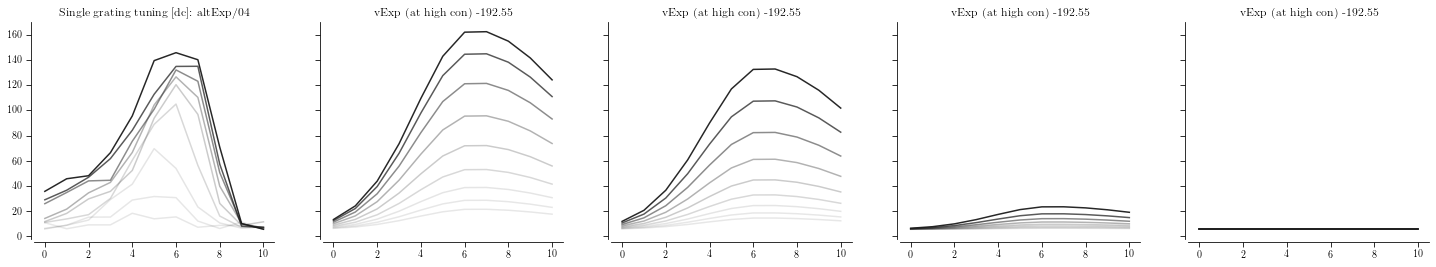

In [3951]:
##### nrow = 5
f, ax = plt.subplots(1,nrow,figsize=(5*nrow,4), sharey=True, sharex=True)

# data
[ax[0].plot(hf.nan_rm(x), color='k', alpha=np.maximum(0.1, i/mod_resps_init.shape[-1])) for i,x in enumerate(np.transpose(expByCond[0]))]
ax[0].set_title('Single grating tuning [%s]: %s/%02d' % ('dc' if respMeasure==0 else 'f1', expDir.replace('/', '').replace('_', ''), cellNum));

# model
[ax[1].plot(hf.nan_rm(x), color='k', alpha=np.maximum(0.1, i/mod_resps_init.shape[-1])) for i,x in enumerate(np.transpose(mod_resps_init[0]))]
ax[1].set_title('vExp (at high con) %.2f' % vExp_init[0,-1]);

# model
[ax[2].plot(hf.nan_rm(x), color='k', alpha=np.maximum(0.1, i/mod_resps_init.shape[-1])) for i,x in enumerate(np.transpose(mod_resps_init_0[0]))]
ax[2].set_title('vExp (at high con) %.2f' % vExp_init[0,-1]);
# model
[ax[3].plot(hf.nan_rm(x), color='k', alpha=np.maximum(0.1, i/mod_resps_init.shape[-1])) for i,x in enumerate(np.transpose(mod_resps_init_1[0]))]
ax[3].set_title('vExp (at high con) %.2f' % vExp_init[0,-1]);

# model
[ax[4].plot(hf.nan_rm(x), color='k', alpha=np.maximum(0.1, i/mod_resps_init.shape[-1])) for i,x in enumerate(np.transpose(mod_resps_init_8[0]))]
ax[4].set_title('vExp (at high con) %.2f' % vExp_init[0,-1]);


sns.despine(offset=3)

In [3965]:
autoreload.reload(mrpt);

In [3975]:
init_prms

(-1.7384488137043257,
 -1.5534626168424466,
 -0.25,
 1,
 3.4991160326363264,
 0,
 5.286663530006056,
 0.28016503429293577,
 0.25477165660944395,
 0.9742147774323595,
 -0.6040946721472662)

In [3995]:
normType = 2

# init_prms = mrpt.setModel(cellNum, expDir=expDir, excType=excType, lossType=lossType, fitType=normType, 
#                           lgnFrontEnd=lgnFrontOn, lgnConType=lgnConType, applyLGNtoNorm=_LGNforNorm,
#                           fixRespExp=fixRespExp, respMeasure=respMeasure, normToOne=True,
#                           newMethod=1, vecCorrected=0, initFromCurr=0, returnOnlyInits=True)
prms_use = np.copy(init_prms);
prms_use[-3] = prms_use[-3]*0.01

init_mod = mrpt.sfNormMod(prms_use, expInd=expInd, excType=excType, normType=normType, lossType=lossType,  
                         newMethod=1, lgnFrontEnd=lgnFrontOn, lgnConType=lgnCon, 
                          applyLGNtoNorm=_applyLGNtoNorm,normToOne=True)


oy = init_mod.genNormWeightsSimple(dw.trInf, recenter_norm=recenter_norm, threshWeights=1e-6);
oy = oy[:,0].detach().numpy();

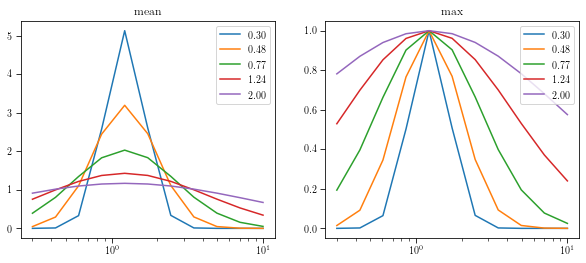

In [4016]:
import torch;
gs_mean = mrpt._cast_as_tensor(0.2);

f, ax = plt.subplots(1,2,figsize=(10,4))

for gs_val in np.geomspace(0.3, 2, 5):
    gs_std = mrpt._cast_as_tensor(gs_val);

    log_sfs = mrpt._cast_as_tensor(np.log(np.geomspace(0.3, 10, 11)))
    weight_distr = torch.distributions.normal.Normal(gs_mean, torch.abs(gs_std))
    
    for i in range(2):
        new_weights = torch.exp(weight_distr.log_prob(log_sfs))
    
        if i == 0:
            new_weights = new_weights/torch.max(mrpt._cast_as_tensor(0.001), torch.mean(new_weights))
        else:
            new_weights = new_weights/torch.max(mrpt._cast_as_tensor(0.001), torch.max(new_weights))
        new_weights = new_weights.detach().numpy();

        ax[i].semilogx(np.exp(log_sfs.detach().numpy()), new_weights, label='%.2f' % gs_val)

for i,ttl in enumerate(['mean', 'max']):
    ax[i].legend();
    ax[i].set_title(ttl);

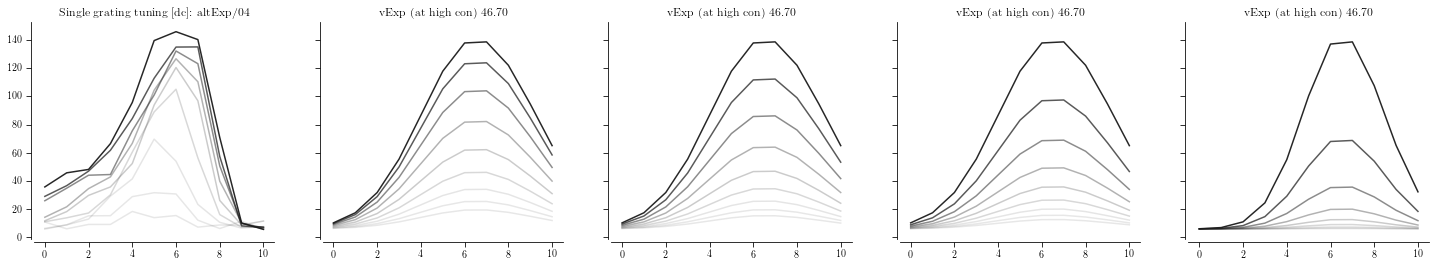

In [3882]:
nrow = 5
f, ax = plt.subplots(1,nrow,figsize=(5*nrow,4), sharey=True, sharex=True)

# data
[ax[0].plot(hf.nan_rm(x), color='k', alpha=np.maximum(0.1, i/mod_resps_init.shape[-1])) for i,x in enumerate(np.transpose(expByCond[0]))]
ax[0].set_title('Single grating tuning [%s]: %s/%02d' % ('dc' if respMeasure==0 else 'f1', expDir.replace('/', '').replace('_', ''), cellNum));

# model
[ax[1].plot(hf.nan_rm(x), color='k', alpha=np.maximum(0.1, i/mod_resps_init.shape[-1])) for i,x in enumerate(np.transpose(mod_resps_init[0]))]
ax[1].set_title('vExp (at high con) %.2f' % vExp_init[0,-1]);

# model
[ax[2].plot(hf.nan_rm(x), color='k', alpha=np.maximum(0.1, i/mod_resps_init.shape[-1])) for i,x in enumerate(np.transpose(mod_resps_init_0[0]))]
ax[2].set_title('vExp (at high con) %.2f' % vExp_init[0,-1]);
# model
[ax[3].plot(hf.nan_rm(x), color='k', alpha=np.maximum(0.1, i/mod_resps_init.shape[-1])) for i,x in enumerate(np.transpose(mod_resps_init_1[0]))]
ax[3].set_title('vExp (at high con) %.2f' % vExp_init[0,-1]);

# model
[ax[4].plot(hf.nan_rm(x), color='k', alpha=np.maximum(0.1, i/mod_resps_init.shape[-1])) for i,x in enumerate(np.transpose(mod_resps_init_8[0]))]
ax[4].set_title('vExp (at high con) %.2f' % vExp_init[0,-1]);


sns.despine(offset=3)

In [3919]:
Linh[sings]

array([0.0727, 0.0727, 0.0727, 0.0727, 0.0727, 0.0727, 0.0727, 0.0727,
       0.0727, 0.0727], dtype=float32)

In [3918]:
Lexc[0, sings]

array([0.03635, 0.03635, 0.03635, 0.03635, 0.03635, 0.03635, 0.03635,
       0.03635, 0.03635, 0.03635], dtype=float32)

In [3909]:
sings

array([ 125,  291,  461,  629,  813,  977, 1141, 1246, 1415, 1560])

In [3914]:
unq_cons = np.unique(dw.trInf['con'][:,0])

In [3927]:
singz = np.where(dw.trInf['con'][:,1]==0)[0] # full contrast, single grats

In [3931]:
oy = Lexc[0,singz]/Linh[singz]

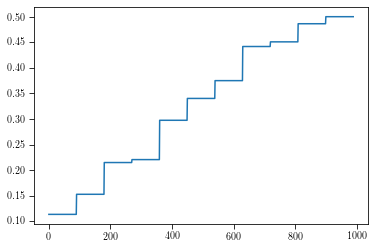

In [3933]:
plt.plot(sorted(oy))

In [3917]:
# sings = np.where(dw.trInf['con'][:,0]==1)[0] # full contrast, single grats
unq_sfs = np.unique(dw.trInf['sf'][:,0])
unq_cons = np.unique(dw.trInf['con'][:,0])
sings = np.where(np.logical_and(dw.trInf['con'][:,0]==unq_cons[1], dw.trInf['sf'][:,0]==unq_sfs[6]))[0] # full contrast, single grats



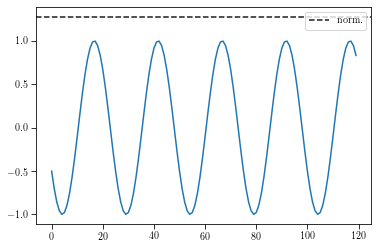

In [3820]:
# Not quadrature...
# curr_tr = np.random.randint(len(sings));
# plt.plot(np.round(Lexc[:,sings[curr_tr]], 4))

# plt.axhline(np.round(Linh[sings[curr_tr]], 4), color='k', linestyle='--', label='norm.')

# plt.legend();

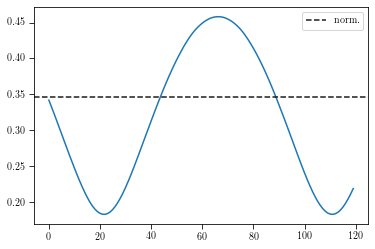

In [3830]:
curr_tr = np.random.randint(Lexc.shape[-1]);
plt.plot(np.round(Lexc[:,curr_tr], 4))
plt.axhline(np.round(Linh[curr_tr], 4), color='k', linestyle='--', label='norm.')

# curr_tr = np.random.randint(len(sings));
# plt.plot(np.round(Lexc[:,sings[curr_tr]], 4))
# plt.axhline(np.round(Linh[sings[curr_tr]], 4), color='k', linestyle='--', label='norm.')

plt.legend();

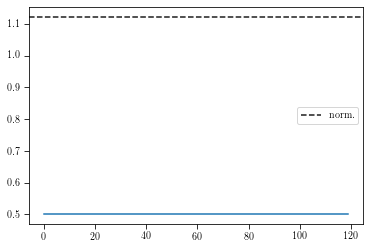

In [3818]:
curr_tr = np.random.randint(len(sings));
plt.plot(np.round(Lexc[:,sings[curr_tr]], 4))

plt.axhline(np.round(Linh[sings[curr_tr]], 4), color='k', linestyle='--', label='norm.')

plt.legend();

Used for T+E meeting, 22.10.13:

In [2708]:
# vt_0 is a reference (single gratings)
ref_con = val_con_by_disp[0][-1];
disp_lvl = 3;
disp_con = val_con_by_disp[disp_lvl][-1]
vt_0 = hf.get_valid_trials(trialInf, 0, ref_con, 5, expInd, stimVals=stimVals, validByStimVal=val_by_stim_val)[0]
vt_1 = hf.get_valid_trials(trialInf, disp_lvl, disp_con, 5, expInd, stimVals=stimVals, validByStimVal=val_by_stim_val)[0]
vt_2 = hf.get_valid_trials(trialInf, disp_lvl, disp_con, 6, expInd, stimVals=stimVals, validByStimVal=val_by_stim_val)[0]
vt_3 = hf.get_valid_trials(trialInf, disp_lvl, disp_con, 7, expInd, stimVals=stimVals, validByStimVal=val_by_stim_val)[0]

# Get them in the correct trials for what we ran the model on
vt_0_adj = np.where(np.in1d(dw.trInf['num'], vt_0))[0]
vt_1_adj = np.where(np.in1d(dw.trInf['num'], vt_1))[0]
vt_2_adj = np.where(np.in1d(dw.trInf['num'], vt_2))[0]
vt_3_adj = np.where(np.in1d(dw.trInf['num'], vt_3))[0]


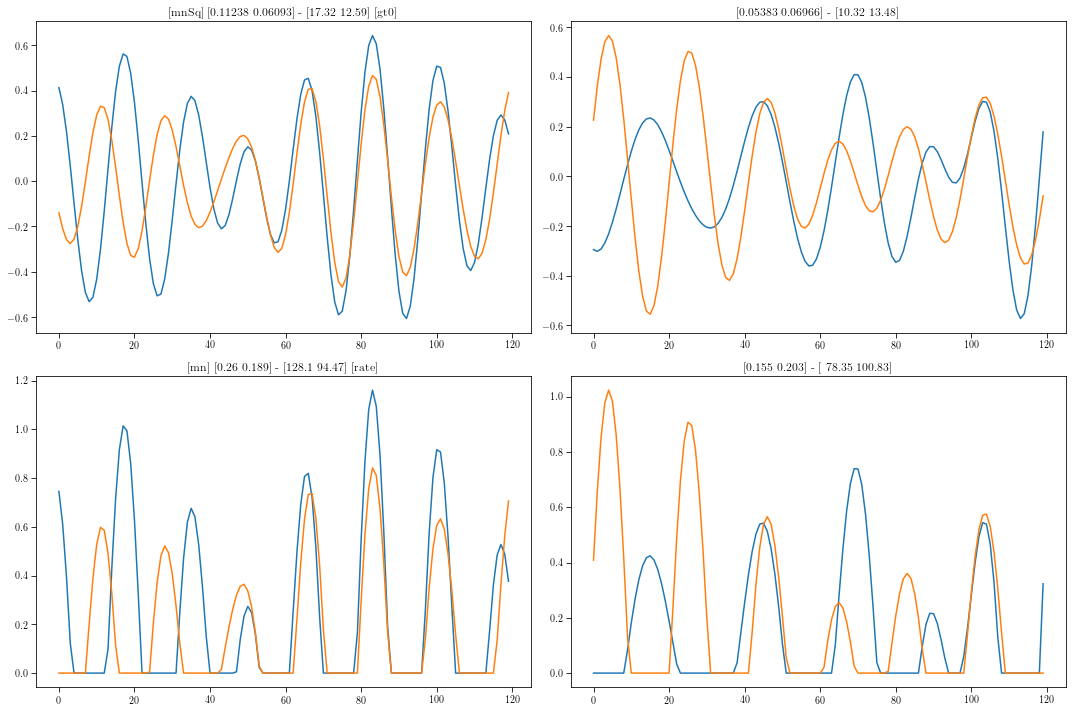

In [2714]:
f, ax = plt.subplots(2,2,figsize=(15,10))

Lexc_sqrd_mn = np.mean(np.square(Lexc),axis=0)
Lexc_pos_sum = np.array([np.sum(x[x>0]) for x in np.transpose(Lexc)])

curr_trs = vt_1_adj;

[ax[0,0].plot(Lexc[:, x]) for x in curr_trs[0:2]];
ax[0,0].set_title('[mnSq] %s - %s [gt0]' % (np.array2string(Lexc_sqrd_mn[curr_trs[0:2]], precision=5), 
                               np.array2string(Lexc_pos_sum[curr_trs[0:2]], precision=2)))
[ax[0,1].plot(Lexc[:, x]) for x in curr_trs[3:5]];
ax[0, 1].set_title('%s - %s' % (np.array2string(Lexc_sqrd_mn[curr_trs[3:5]], precision=5), 
                               np.array2string(Lexc_pos_sum[curr_trs[3:5]], precision=2)))

# and full model resp:
thresh_mn = np.array([np.mean(mod_resps[x]) for x in curr_trs]);
[ax[1,0].plot(mod_resps[x,:]) for x in curr_trs[0:2]];
ax[1,0].set_title('[mn] %s - %s [rate]' % (np.array2string(thresh_mn[0:2], precision=3), 
                                           np.array2string(modResp[curr_trs[0:2]], precision=2)))
[ax[1,1].plot(mod_resps[x,:]) for x in curr_trs[3:5]];
ax[1,1].set_title('%s - %s' % (np.array2string(thresh_mn[3:5], precision=3), np.array2string(modResp[curr_trs[3:5]], precision=2)))

f.tight_layout();


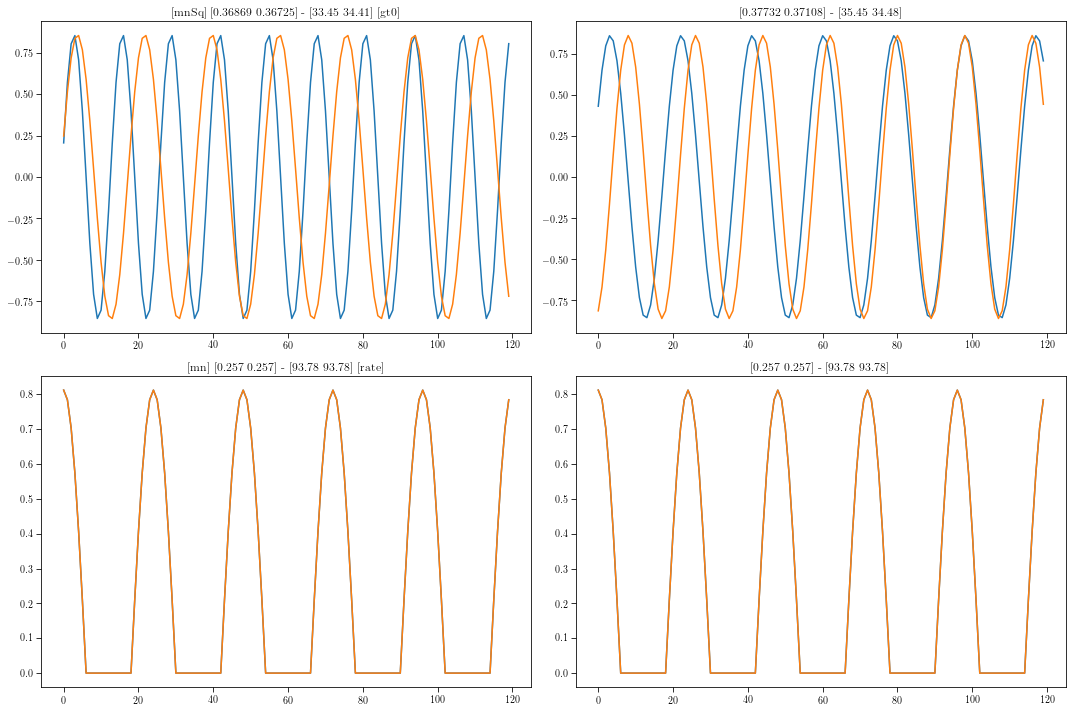

In [2680]:
f, ax = plt.subplots(2,2,figsize=(15,10))

Lexc_sqrd_mn = np.mean(np.square(Lexc),axis=0)
Lexc_pos_sum = np.array([np.sum(x[x>0]) for x in np.transpose(Lexc)])

curr_trs = vt_0_adj;

[ax[0,0].plot(Lexc[:, x]) for x in curr_trs[0:2]];
ax[0,0].set_title('[mnSq] %s - %s [gt0]' % (np.array2string(Lexc_sqrd_mn[curr_trs[0:2]], precision=5), 
                               np.array2string(Lexc_pos_sum[curr_trs[0:2]], precision=2)))
[ax[0,1].plot(Lexc[:, x]) for x in curr_trs[3:5]];
ax[0, 1].set_title('%s - %s' % (np.array2string(Lexc_sqrd_mn[curr_trs[3:5]], precision=5), 
                               np.array2string(Lexc_pos_sum[curr_trs[3:5]], precision=2)))

# and full model resp:
thresh_mn = np.array([np.mean(mod_resps[x]) for x in curr_trs]);
[ax[1,0].plot(mod_resps[x,:]) for x in curr_trs[0:2]];
ax[1,0].set_title('[mn] %s - %s [rate]' % (np.array2string(thresh_mn[0:2], precision=3), 
                                           np.array2string(modResp[curr_trs[0:2]], precision=2)))
[ax[1,1].plot(mod_resps[x,:]) for x in curr_trs[3:5]];
ax[1,1].set_title('%s - %s' % (np.array2string(thresh_mn[3:5], precision=3), np.array2string(modResp[curr_trs[3:5]], precision=2)))

f.tight_layout();


##### Extra: Quadrature
Will work once you've specified model.   
**ALSO, must modify simpleResp_matMul** to return all four filters, rather than the one filter which it defaults to (will need to edit the return in model_responses_pytorch.py --> simpleResp_matMul function

In [3521]:
def allResp(r1,r2,r3,r4, wThresh=False):
    if wThresh:
        oy = np.square(np.maximum(1e-6, r1)) + np.square(np.maximum(1e-6, r2))+ np.square(np.maximum(1e-6, r3)) + np.square(np.maximum(1e-6, r4));
    else:
        oy = np.square(r1) + np.square(r2) + np.square(r3) + np.square(r4);

    return np.sqrt(oy/4);

In [3522]:
rs1,rs2,rs3,rs4 = model.simpleResp_matMul(dw.trInf, sigmoidSigma=sigmoidSigma);
rs1 = rs1.detach().numpy();
rs2 = rs2.detach().numpy();
rs3 = rs3.detach().numpy();
rs4 = rs4.detach().numpy();

rAll = allResp(rs1, rs2, rs3, rs4);
rAll_thresh = allResp(rs1, rs2, rs3, rs4, wThresh=True);

ValueError: too many values to unpack (expected 4)

##### How different is the quadrature result from not?

First, the single grating:

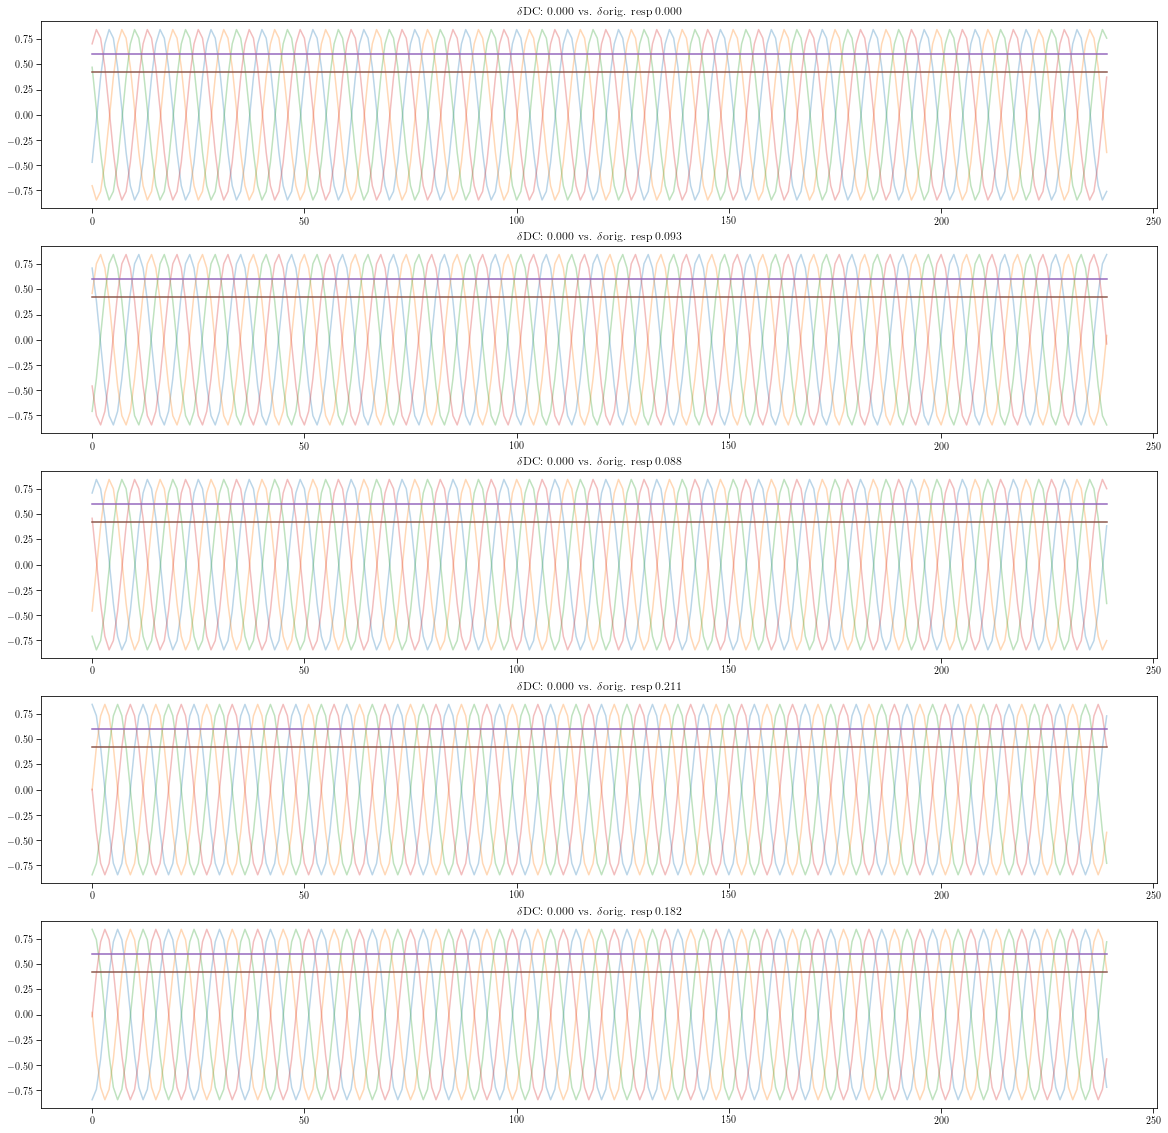

In [2547]:
n_trs = 5;
f, ax  = plt.subplots(nrows=n_trs, ncols=1, figsize=(20,n_trs*4));

for tr in range(n_trs):

    curr_tr = vt_0_adj[tr];
    ax[tr].plot(rs1[:, curr_tr], alpha=0.3)
    ax[tr].plot(rs2[:, curr_tr], alpha=0.3)
    ax[tr].plot(rs3[:, curr_tr], alpha=0.3)
    ax[tr].plot(rs4[:, curr_tr], alpha=0.3)

    ax[tr].plot(rAll[:, curr_tr]);
    ax[tr].plot(rAll_thresh[:, curr_tr]);
    
    if tr == 0:
        fft_ref = hf.spike_fft([rAll[:,curr_tr]], tfs=None, stimDur=2)[0][0][0]
        mr_ref = modResp[curr_tr];
    
    fft_dc = hf.spike_fft([rAll[:,curr_tr]], tfs=None, stimDur=2)[0][0][0]
    ax[tr].set_title(r'$\delta$DC: %.3f vs. $\delta$orig. resp %.3f' % (100*((fft_dc-fft_ref)/fft_ref), 
                                                       100*((modResp[curr_tr]-mr_ref)/mr_ref)))

Then, the mixtures:

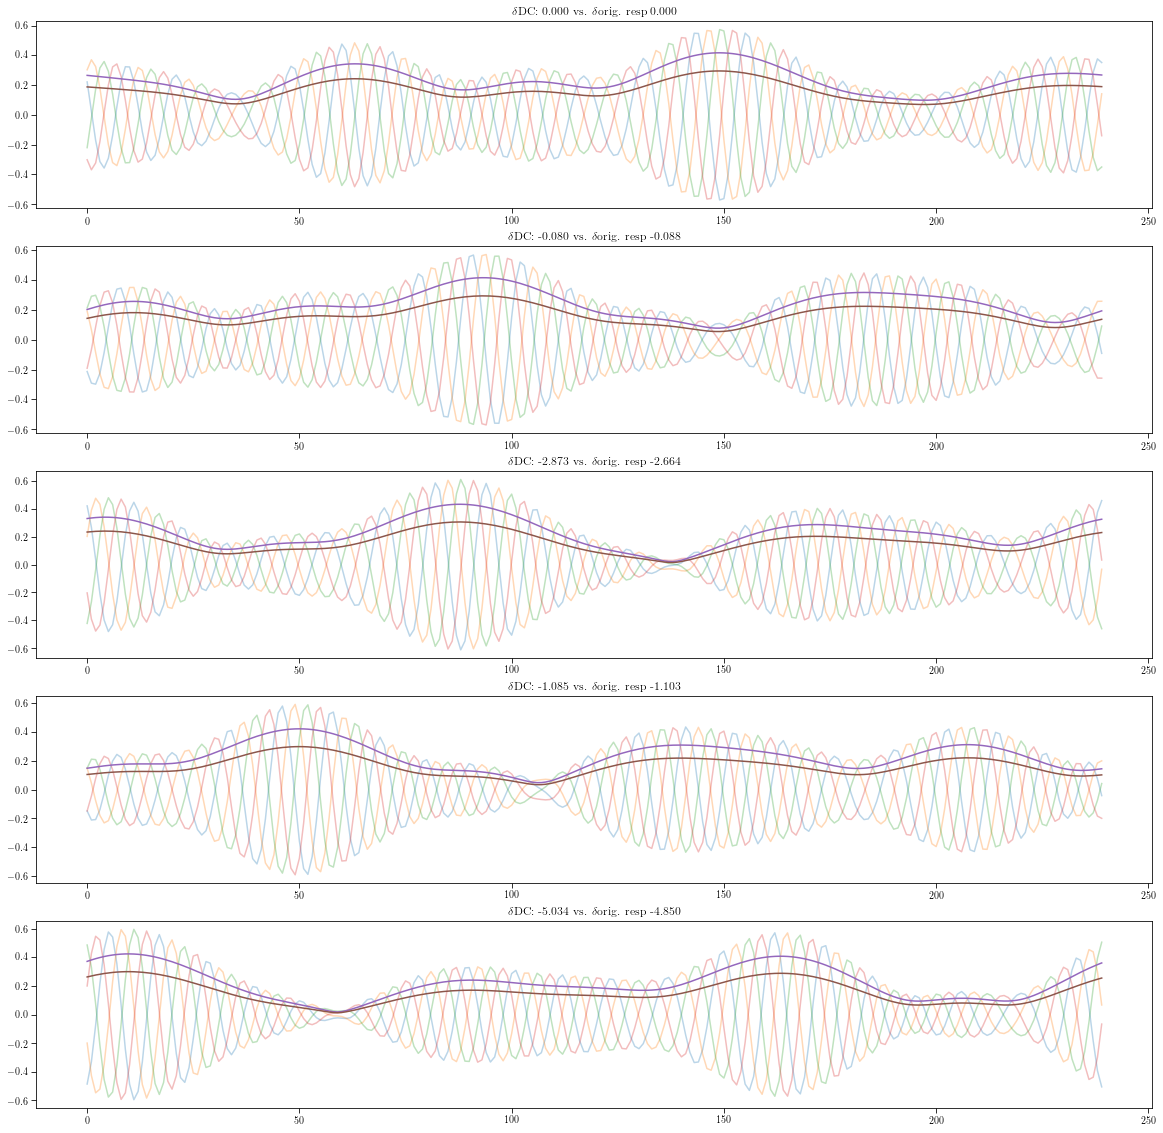

In [2546]:
n_trs = 5;
f, ax  = plt.subplots(nrows=n_trs, ncols=1, figsize=(20,n_trs*4));

for tr in range(n_trs):

    curr_tr = vt_1_adj[tr];
    ax[tr].plot(rs1[:, curr_tr], alpha=0.3)
    ax[tr].plot(rs2[:, curr_tr], alpha=0.3)
    ax[tr].plot(rs3[:, curr_tr], alpha=0.3)
    ax[tr].plot(rs4[:, curr_tr], alpha=0.3)

    ax[tr].plot(rAll[:, curr_tr]);
    ax[tr].plot(rAll_thresh[:, curr_tr]);
    
    if tr == 0:
        fft_ref = hf.spike_fft([rAll[:,curr_tr]], tfs=None, stimDur=2)[0][0][0]
        mr_ref = modResp[curr_tr];
    
    fft_dc = hf.spike_fft([rAll[:,curr_tr]], tfs=None, stimDur=2)[0][0][0]
    ax[tr].set_title(r'$\delta$DC: %.3f vs. $\delta$orig. resp %.3f' % (100*((fft_dc-fft_ref)/fft_ref), 
                                                       100*((modResp[curr_tr]-mr_ref)/mr_ref)))